In [1]:
#!pip install spectral

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.graph_objects as go
import plotly
import plotly.express as px

#from spectral import imshow, view_cube
#import spectral.io.envi as envi


## Inforamções aleatórias

usar so antigeno, controle e interferencia (outras coisas que nao é o antigeno)

coluna 1 e 2: coordenada da imagem
coluna 3: comprimento de onda
coluna 4: intensidade do elemento

plotar intensidade x comprimento: espectro


para cada pixel tem um array que é o espectro. E cada espectro tem 1014 comprimento de ondas.

se parar no comprimento de onda e olha os dados (os pixels) vemos a imagem


cada espectro tem 1014 linhas. com 441 espectros (21 linhas x 21 colunas)


olhar para comprimento de onda de onde esta o pico.

espectro medio

o objeto de dado é o cubo. dentro daquele cubo temos que saber quais atributos são importantes

ver imagem basta fixar os espectros e percorrer as coordenadas 

1079, cm^-1, pico de tudo

### Lendo os arquivos do diretório

In [2]:
antigenPath = 'dados/sers/antigen'
controlPath = 'dados/sers/control'
interferingPath = 'dados/sers/interfering'



def validate_data_shape(data, expected_num_spectra, points_per_spectrum, file_name):
    if not data.shape[0] == expected_num_spectra * points_per_spectrum:
        raise Exception(
            'Error in file {}. Number of spectra ({}) unexpected.'.format(file_name, data.shape[0])
        )


def process_copy(data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name):
    spec_start = spec_number * points_per_spectrum
    spec_end = (spec_number + 1) * points_per_spectrum
    position_x = int(data[spec_start, 0])
    position_y = int(data[spec_start, 1])

    if is_initial_spec:
        current_raman_shift = data[spec_start:spec_end, -2]
        is_initial_spec = False
    else:
        if not np.array_equal(data[spec_start:spec_end, -2], previous_raman_shift):
            raise Exception(
                'Error in file {}, spec number {}. Raman Shift axis is different.'.format(file_name, spec_number)
            )
        else:
            current_raman_shift = data[spec_start:spec_end, -2]

    return spec_start, spec_end, position_x, position_y, current_raman_shift, is_initial_spec


def create_dataframe_from_files(file_list):
    spectra_data = []
    positions_data = []
    is_initial_spec = True
    num_spectra = 441
    points_per_spectrum = 1014
    map_counter = 0
    previous_raman_shift = None

    for file_name in file_list:
        data = np.loadtxt(file_name, delimiter="\t")
        validate_data_shape(data, num_spectra, points_per_spectrum, file_name)

        num_specs = data.shape[0] / points_per_spectrum
        print(file_name, num_specs)

        for spec_number in range(int(num_specs)):
            spec_start, spec_end, position_x, position_y, previous_raman_shift, is_initial_spec = process_copy(
                data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name
            )

            spectra_data.append(data[spec_start:spec_end, -1])
            positions_data.append([position_x, position_y, spec_number, map_counter])

        map_counter += 1

    df_spectra = pd.DataFrame(data=spectra_data, columns=data[spec_start:spec_end, -2])
    df_positions = pd.DataFrame(data=positions_data, columns=['x', 'y', 'spec_number', 'map'])
    df_combined = pd.concat([df_spectra, df_positions], axis=1)
    df_combined = df_combined.sort_values(by=['map', 'spec_number'], ignore_index=True)
    return df_combined

def create_datasets(antigen_path, control_path, interfering_path):
    antigen_files = next(os.walk(antigen_path), (None, None, []))[2]
    control_files = next(os.walk(control_path), (None, None, []))[2]
    interfering_files = next(os.walk(interfering_path), (None, None, []))[2]

    antigen_data = create_dataframe_from_files([os.path.join(antigen_path, file_name) for file_name in antigen_files])
    control_data = create_dataframe_from_files([os.path.join(control_path, file_name) for file_name in control_files])
    interfering_data = create_dataframe_from_files([os.path.join(interfering_path, file_name) for file_name in interfering_files])

    return antigen_data, control_data, interfering_data


def merge_datasets(antigen_data, control_data, interfering_data):
    # Add a new column with values 0 for control, 1 for antigen, and 2 for interfering
    antigen_data['target'] = 1
    control_data['target'] = 0
    interfering_data['target'] = 2

    # Concatenate the three dataframes vertically
    merged_data = pd.concat([antigen_data, control_data, interfering_data], axis=0)
    merged_data = merged_data.reset_index(drop = True)

    return merged_data

antigen_data, control_data, interfering_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data = merge_datasets(antigen_data, control_data, interfering_data)
#raw_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data

dados/sers/antigen\antigeno1.txt 441.0


dados/sers/antigen\antigeno10.txt 441.0
dados/sers/antigen\antigeno11.txt 441.0
dados/sers/antigen\antigeno12.txt 441.0
dados/sers/antigen\antigeno13.txt 441.0
dados/sers/antigen\antigeno14.txt 441.0
dados/sers/antigen\antigeno15.txt 441.0
dados/sers/antigen\antigeno16.txt 441.0
dados/sers/antigen\antigeno2.txt 441.0
dados/sers/antigen\antigeno3.txt 441.0
dados/sers/antigen\antigeno4.txt 441.0
dados/sers/antigen\antigeno5.txt 441.0
dados/sers/antigen\antigeno6.txt 441.0
dados/sers/antigen\antigeno7.txt 441.0
dados/sers/antigen\antigeno8.txt 441.0
dados/sers/antigen\antigeno9.txt 441.0
dados/sers/control\controle1.txt 441.0
dados/sers/control\controle10.txt 441.0
dados/sers/control\controle11.txt 441.0
dados/sers/control\controle12.txt 441.0
dados/sers/control\controle13.txt 441.0
dados/sers/control\controle14.txt 441.0
dados/sers/control\controle15.txt 441.0
dados/sers/control\controle16.txt 441.0
dados/sers/control\controle17.txt 441.0
dados/sers/control\controle18.txt 441.0
dados/ser

1611.19  1610.19  1609.18  1608.18  1607.17  1606.17  1605.16  1604.16  \
0      1971.64  2113.54  2145.43  2147.46  2134.56  2268.41  2310.19  2478.76   
1      2061.26  2096.11  2093.17  2199.71  2214.17  2273.38  2404.69  2446.44   
2      2043.83  2036.36  2080.72  2149.95  2176.85  2328.10  2327.60  2516.05   
3      2001.51  2041.34  2068.28  2102.67  2216.65  2233.59  2322.63  2545.88   
4      2031.38  2098.60  2120.55  2192.25  2236.56  2365.41  2302.73  2458.87   
...        ...      ...      ...      ...      ...      ...      ...      ...   
20281  1540.96  1687.84  1754.68  1716.97  1826.07  1738.62  1927.23  1894.50   
20282  1610.67  1635.56  1692.45  1712.00  1763.87  1870.44  1780.51  1929.30   
20283  1690.33  1672.90  1699.92  1754.30  1796.21  1882.88  1932.21  1966.60   
20284  1700.29  1692.82  1687.48  1684.62  1726.55  1798.31  1894.91  1929.30   
20285  1682.86  1702.78  1757.17  1726.93  1751.43  1858.01  1907.34  1914.39   

       1603.15  1602.14  ...  476.105   474.84  473.574  472.308  471.042   x  \
0      2607.48  2793.30  ...  855.849  879.351  883.085  853.242  892.524 -10   
1      2649.73  2818.15  ...  873.638  865.518  875.183  872.993  904.372 -10   
2      2649.73  2778.39  ...  828.177  887.255  902.841  872.993  849.083 -10   
3      2595.05  2828.09  ...  855.849  859.590  867.281  916.445  922.143 -10   
4      2652.22  2808.21  ...  897.356  907.016  918.646  928.295  876.727 -10   
...        ...      ...  ...      ...      ...      ...      ...      ...  ..   
20281  1983.57  2154.62  ...  679.935  650.127  673.674  647.832  649.647  10   
20282  1963.69  2162.07  ...  658.193  695.576  681.576  635.981  657.545  10   
20283  2025.83  2109.89  ...  636.451  661.983  663.796  709.060  649.647  10   
20284  2035.77  2157.10  ...  677.959  669.887  661.820  651.782  681.241  10   
20285  2075.54  2154.62  ...  662.146  687.672  719.112  657.707  663.469  10   

        y  spec_number  map  target  
0     -10            0    0       1  
1      -9            1    0       1  
2      -8            2    0       1  
3      -7            3    0       1  
4      -6            4    0       1  
...    ..          ...  ...     ...  
20281   6          436    9       2  
20282   7          437    9       2  
20283   8          438    9       2  
20284   9          439    9       2  
20285  10          440    9       2  

[20286 rows x 1019 columns]

In [3]:

def count_per_class_and_map(df_out):
    count = df_out.groupby(['target', 'map'])['map'].count()
    return count


# Example usage:
count_maps = count_per_class_and_map(raw_data)
count_maps

target  map
0       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
        16     441
        17     441
        18     441
        19     441
1       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
2       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
Name: map, dtype: int64

In [4]:
def countValues(array):
    return pd.DataFrame(array.value_counts())

targets = raw_data.iloc[:,-1]
countValues(targets)

target
0    8820
1    7056
2    4410

In [5]:
columns = raw_data.columns
countValues(columns)

0
1611.19  1
871.124  1
886.279  1
885.115  1
883.951  1
...     ..
1252.82  1
1251.74  1
1250.66  1
1249.58  1
target   1

[1019 rows x 1 columns]

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20286 entries, 0 to 20285
Columns: 1019 entries, 1611.19 to target
dtypes: float64(1014), int64(5)
memory usage: 157.7 MB


In [7]:
## 21 x 21 x 1014 = 441 (number of waves) x 1014 (lenght of a wave)
def filter_dataframe(df, condition_column, condition_value):
    filtered_df = df[df[condition_column] != condition_value]
    #remaining_df = df[df[condition_column] == condition_value]
    return filtered_df, df

raw_data, remaining_raw_data = filter_dataframe(raw_data, 'target', 2)
raw_data

1611.19  1610.19  1609.18  1608.18  1607.17  1606.17  1605.16  1604.16  \
0      1971.64  2113.54  2145.43  2147.46  2134.56  2268.41  2310.19  2478.76   
1      2061.26  2096.11  2093.17  2199.71  2214.17  2273.38  2404.69  2446.44   
2      2043.83  2036.36  2080.72  2149.95  2176.85  2328.10  2327.60  2516.05   
3      2001.51  2041.34  2068.28  2102.67  2216.65  2233.59  2322.63  2545.88   
4      2031.38  2098.60  2120.55  2192.25  2236.56  2365.41  2302.73  2458.87   
...        ...      ...      ...      ...      ...      ...      ...      ...   
15871  2320.16  2412.27  2454.06  2525.69  2557.49  2499.73  2722.99  2841.74   
15872  2392.35  2447.12  2481.44  2528.18  2599.78  2636.53  2747.86  2881.52   
15873  2367.46  2374.93  2464.01  2627.71  2559.97  2671.35  2805.06  2881.52   
15874  2367.46  2442.14  2526.24  2538.13  2629.63  2614.14  2785.16  2916.33   
15875  2412.27  2412.27  2421.70  2470.95  2634.61  2736.02  2797.60  2985.94   

       1603.15  1602.14  ...   476.105    474.84   473.574   472.308  \
0      2607.48  2793.30  ...   855.849   879.351   883.085   853.242   
1      2649.73  2818.15  ...   873.638   865.518   875.183   872.993   
2      2649.73  2778.39  ...   828.177   887.255   902.841   872.993   
3      2595.05  2828.09  ...   855.849   859.590   867.281   916.445   
4      2652.22  2808.21  ...   897.356   907.016   918.646   928.295   
...        ...      ...  ...       ...       ...       ...       ...   
15871  3037.50  3265.48  ...  1081.180  1027.560  1084.590  1098.150   
15872  3062.36  3307.72  ...  1087.110  1074.980  1078.670  1165.310   
15873  3052.41  3258.02  ...  1065.360  1106.600  1064.840  1113.950   
15874  3022.59  3287.84  ...  1083.150  1041.390  1070.770  1110.000   
15875  3144.38  3267.96  ...  1102.920  1078.930  1139.910  1151.480   

        471.042   x   y  spec_number  map  target  
0       892.524 -10 -10            0    0       1  
1       904.372 -10  -9            1    0       1  
2       849.083 -10  -8            2    0       1  
3       922.143 -10  -7            3    0       1  
4       876.727 -10  -6            4    0       1  
...         ...  ..  ..          ...  ...     ...  
15871  1099.860  10   6          436   19       0  
15872  1147.250  10   7          437   19       0  
15873  1131.450  10   8          438   19       0  
15874  1168.970  10   9          439   19       0  
15875  1109.730  10  10          440   19       0  

[15876 rows x 1019 columns]

# Data Visualization

## Signal visualization

In [8]:
def plotParallelCoordinates(df, title, xlabel, ylabel, target = 'target', colors = ['red', 'blue', 'green']):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,15))
    new_df = df.copy()
    pd.plotting.parallel_coordinates(frame = new_df, class_column = target, ax = ax, color = colors)
    ax.set(title = title,
           xlabel = xlabel,
           ylabel = ylabel)
    plt.xticks(rotation = 45, fontsize = 10)
    #ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
    plt.show()



def plotSersSignal(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16,12))

    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    dataframe_melted = dataframe.melt(id_vars=target_column, value_vars=columns, var_name="Wavelength (1/cm)", value_name="Intensity (u.a.)")
    sns.lineplot(data=dataframe_melted, x="Wavelength (1/cm)", y="Intensity (u.a.)", hue=target_column, markers=True)

    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Intensity (u.a.)')
    plt.title('SERS Signal')
    plt.legend()
    plt.xticks(rotation=45)  # Set x-axis ticks to go from 50 to 50 values
    #plt.tight_layout()
    plt.show()
    
def plotAverageSpectra(dataframe):
    # Exclude the "target" column
    data = dataframe.drop("target", axis=1)
    
    # Group the dataframe by the "target" column
    grouped_data = dataframe.groupby("target")
    
    # Set up the plot
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the column names for plotting
    columns = data.columns
    
    # Iterate over each group
    for group_name, group_data in grouped_data:
        # Calculate the average of each column within the group
        average_spectrum = group_data.iloc[:, :-1].median(axis=0)        
        # Plot the average spectrum as a line graph
        sns.lineplot(x=columns, y=average_spectrum, label=group_name, linewidth=2)
    
    # Set the x and y labels, title, and legend
    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Mean Intensity (u.a.)')
    plt.title('Average Spectra of each group')
    plt.legend()
    
    # Display the plot
    plt.show()

def plotMultipleSersSignals(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in dataframe.iterrows():
        signal = row.drop("target")  # Exclude the "target" column
        sns.lineplot(x=signal.columns, y=signal.values, label=row["target"], linewidth=2)

    plt.xlabel('Points')
    plt.ylabel('Intensity')
    plt.title('Multiple SERS Signals')
    plt.legend(title="Target")
    plt.show()


def plotMedianSpectra(dataframe):
    # Group the dataframe by the "target" column and calculate the median for each variable within each group
    grouped_median = dataframe.groupby("target").mean()

    # Set up the plot
    fig = go.Figure()

    # Iterate over each group
    for group_name, group_data in grouped_median.iterrows():
        # Plot the average spectrum as a line graph
        fig.add_trace(go.Scatter(x=dataframe.drop("target", axis=1).columns,
                                 y=group_data,
                                 mode='lines',
                                 name=str(group_name)))

    # Set the x and y labels, title, and legend
    fig.update_layout(title="SERS",
                      xaxis_title="Wavelength (1/cm)",
                      yaxis_title="Intensity (u.a.)",
                      legend_title="Target")

    # Display the plot
    fig.show()


X = raw_data.drop(['x','y','spec_number','map'], axis = 1)
#plotMultipleSersSignals(X)
# plotAverageSpectra(X)
plotMedianSpectra(X)

In [9]:
X2 = remaining_raw_data.drop(['x','y','spec_number','map'], axis = 1)
plotMedianSpectra(X2)

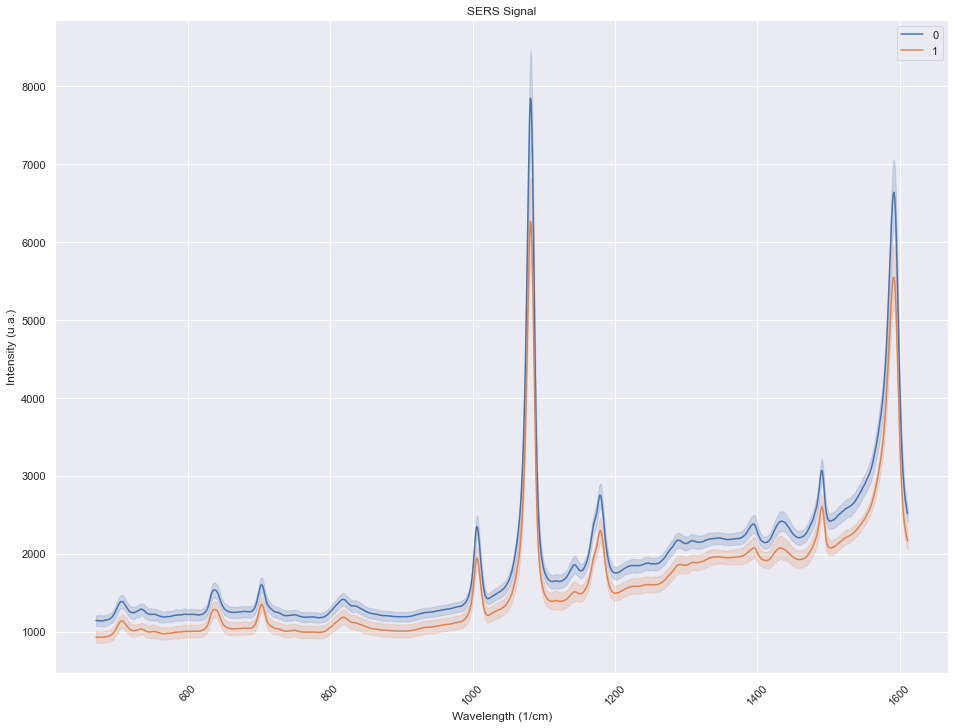

In [10]:
def groupMaps(df):
    # Group the data by the "map" and "target" columns and calculate the sum of each group divided by 441
    grouped_df = df.groupby(['map', 'target']).mean()

    # Reset the index of the grouped DataFrame to make "map" a regular column
    grouped_df = grouped_df.reset_index()

    return grouped_df

def plotSersSignal_v2(dataframe):
    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    # Generate a color map for each target
    color_map = px.colors.qualitative.Plotly

    fig = go.Figure()

    for i, target in enumerate(dataframe[target_column].unique()):
        df_target = dataframe[dataframe[target_column] == target]
        target_color = color_map[i % len(color_map)]  # Assign a color from the color map

        # Add trace for each class with its corresponding legend
        target_name = str(target)  # Convert the target to a string
        fig.add_trace(go.Scatter(x=df_target[columns].columns, y=df_target[columns].values[0],
                                 mode='lines+markers', name=target_name, line=dict(width=2, color=target_color)))

    fig.update_layout(
        title="SERS Signal",
        xaxis_title="Wavelength (1/cm)",
        yaxis_title="Intensity (u.a.)",
        legend_title=target_column,
        xaxis=dict(tickangle=45),
        showlegend=True,
        width=900,
        height=600
    )

    fig.show()



X = raw_data.drop(columns = ['x','y','spec_number'], axis = 1)
map_data = groupMaps(X)

X_map = map_data.drop(columns = ['map'], axis = 1)
plotSersSignal(X_map)

In [11]:
plotSersSignal_v2(X_map)

In [12]:
def plotSignal_v3(dataframe, title):
    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    # Generate a color map for each target
    color_map = px.colors.qualitative.Plotly

    fig = go.Figure()

    for i, target in enumerate(dataframe[target_column].unique()):
        df_target = dataframe[dataframe[target_column] == target]
        target_color = color_map[i % len(color_map)]  # Assign a color from the color map

        # Convert the target value to a string for the legend
        target_legend = str(target)

        # Add trace for each row in the DataFrame
        for idx, row in df_target.iterrows():
            target_name = target_legend + " - Sample " + str(idx)  # Use the target_legend for the legend name
            fig.add_trace(go.Scatter(x=columns, y=row[columns],
                                     mode='lines+markers', name=target_name, line=dict(width=2, color=target_color)))

    fig.update_layout(
        title=title,
        xaxis_title="tensão (µV)",
        yaxis_title="corrente (µA)",
        legend_title="Class",  # Set the legend title to "Class" or any desired label
        xaxis=dict(tickangle=45),
        showlegend=True,
        width=900,
        height=600
    )

    fig.show()

plotSignal_v3(X_map, 'SERS Signal')

## Map visualization

C:\Users\Lucas\AppData\Local\Temp\ipykernel_10660\124970333.py:71: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Lucas\AppData\Local\Temp\ipykernel_10660\124970333.py:75: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Lucas\AppData\Local\Temp\ipykernel_10660\124970333.py:76: UserWarning:

FixedFormatter should only be used together with FixedLocator



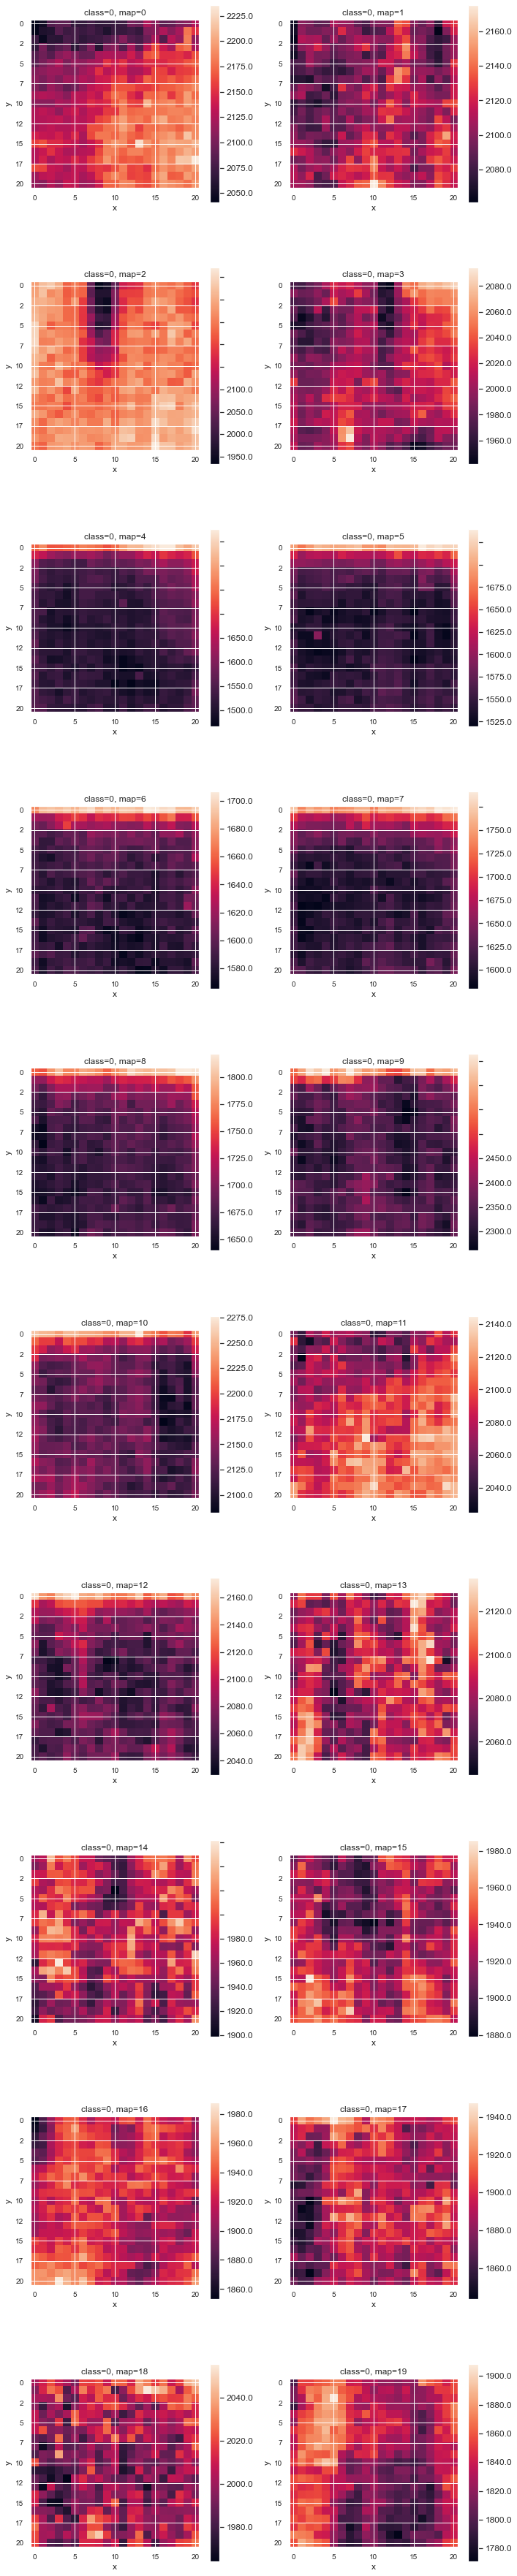

In [13]:
import math
from matplotlib.ticker import FuncFormatter
from plotly.subplots import make_subplots
import plotly.subplots as sp


def plotSERSMaps(df, dim, target_class):
    unique_maps = getUniqueMaps(df, target_class)
    n_rows, n_cols = calculateGridSize(unique_maps)
    figsize = calculateFigSize(n_rows)
    fig, axes = createSubplots(n_rows, n_cols, figsize)
    
    for i, mp in enumerate(unique_maps):
        ax = axes[i]
        subset = getSubset(df, target_class, mp)
        
        if subset.empty:
            hideSubplot(ax)
            continue
        
        mi = calculateMeanIntensity(subset, dim)
        im = plotIntensityMap(ax, mi, target_class, mp)
        addColorbar(im, ax)
        setTickLabels(ax)
    
    hideExtraSubplots(len(unique_maps), n_rows, n_cols, axes)
    setLayout()
    showPlot()


def getUniqueMaps(df, target_class):
    return df.loc[df['target'] == target_class, 'map'].unique()


def calculateGridSize(unique_maps):
    n_rows = math.ceil(len(unique_maps) / 2)
    n_cols = 2
    return n_rows, n_cols


def calculateFigSize(n_rows):
    return (10, 5 * n_rows)


def createSubplots(n_rows, n_cols, figsize):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    return fig, axes


def getSubset(df, target_class, mp):
    return df.loc[(df['target'] == target_class) & (df['map'] == mp)]


def hideSubplot(ax):
    ax.axis('off')


def calculateMeanIntensity(subset, dim):
    return subset.iloc[:, :-5].mean(axis=1).values.reshape(dim, dim)


def plotIntensityMap(ax, mi, target_class, mp):
    im = ax.imshow(mi)
    ax.set_title(f'class={target_class}, map={mp}')
    return im


def addColorbar(im, ax):
    cb = plt.colorbar(im, shrink=0.825, ax=ax)
    cb.ax.set_yticklabels(cb.ax.get_yticks(), fontsize=12)


def setTickLabels(ax):
    ax.set_xticklabels(ax.get_xticks(), size=10)
    ax.set_yticklabels(ax.get_yticks(), size=10)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))


def hideExtraSubplots(num_maps, n_rows, n_cols, axes):
    for j in range(num_maps, n_rows * n_cols):
        axes[j].axis('off')


def setLayout():
    plt.tight_layout()


def showPlot():
    plt.show()


dim = 21  # Define the number of pixels per row/column
plotSERSMaps(raw_data, dim, 0)


In [14]:
#plotSERSMaps(raw_data, dim, 1)

## Box plots

In [15]:
def boxPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        sns.boxplot(data=df, x=col, y=hue, ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel(hue)
    plt.tight_layout()
    plt.show()

def plotGroupedBoxplot(signal):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a list to hold the data for each column
    data = [signal.iloc[:, i] for i in range(signal.shape[1])]
    
    # Generate positions for the boxplots along the x-axis
    positions = np.arange(1, signal.shape[1] + 1)
    
    # Create the grouped boxplot
    ax.boxplot(data, positions=positions, patch_artist=True, medianprops={'color': 'black'})
    
    # Set the x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(signal.columns)
    ax.set_xlabel('Columns')
    
    # Set the y-axis label
    ax.set_ylabel('Values')
    
    # Set the plot title
    ax.set_title('Grouped Boxplot of Signal Columns')
    
    # Adjust the layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


def plotBoxplotEveryXColumns(dataframe, x):
    num_cols = dataframe.shape[1]
    num_plots = num_cols // x + 1 if num_cols % x != 0 else num_cols // x

    fig, axes = plt.subplots(nrows=num_plots, figsize=(12, 6*num_plots))

    for i in range(num_plots):
        start_idx = i * x
        end_idx = start_idx + x
        subset = dataframe.iloc[:, start_idx:end_idx]
        
        ax = axes[i] if num_plots > 1 else axes
        ax.boxplot(subset.values, patch_artist=True)
        ax.set_xticklabels(subset.columns, rotation=45)
        ax.set_xlabel('Columns')
        ax.set_ylabel('Value')
        ax.set_title(f'Boxplot of Columns {start_idx+1} to {end_idx}')

    plt.tight_layout()
    plt.show()

#boxPlot(X, 'target')
signals = X.drop(['target'], axis = 1)
#plotBoxplotEveryXColumns(signals, 15)

In [16]:

def plot_boxplot_for_each_row(data_frame):

    # Create a list to store individual boxplots
    boxplots = []

    # Loop through each row and create a boxplot for each row
    for index, row in data_frame.iterrows():
        boxplot = go.Box(
            y=row,
            name=f"target = {index}",
            boxpoints=False  # Set to False to hide individual data points
        )
        boxplots.append(boxplot)

    # Create the layout for the plot
    layout = go.Layout(title="Boxplot for each class",
                       xaxis=dict(title="Features"),
                       yaxis=dict(title="Signal Values"))

    # Create the figure and add the boxplots
    fig = go.Figure(data=boxplots, layout=layout)

    # Show the plot
    fig.show()




X_map = map_data.drop(['map'], axis = 1)
grouped_map = X_map.groupby('target').median()
# print(grouped_map)
plot_boxplot_for_each_row(grouped_map)

## Histograms

In [17]:
def histPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        #print(df[col].value_counts())
        sns.histplot(data=df, x=col, hue = hue, kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

#histPlot(X, 'target')

# Statistics

## From rows

In [18]:
from scipy.stats import kurtosis, skew

def extractingRowStatistics(df):

    stats_df = pd.DataFrame(columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for i in range(len(df)):
        sample = df.iloc[i].values
        stats_df.loc[i] = [np.mean(sample), 
                           np.std(sample),
                           np.min(sample),
                           np.quantile(sample, 0.25),
                           np.quantile(sample, 0.5),
                           np.quantile(sample, 0.75),
                           np.max(sample),
                           skew(sample),
                           kurtosis(sample)
                           ]
    return stats_df

stats_row = extractingRowStatistics(X)
stats_row['target'] = X['target']
stats_row

mean         std  min         25%       50%        75%      max  \
0      1524.440394  732.408703  0.0   982.51975  1321.610  1853.9550  5718.68   
1      1535.332661  742.711659  0.0   992.97700  1323.975  1871.1125  5808.10   
2      1537.410078  744.024732  0.0   996.07600  1326.035  1874.2675  5886.35   
3      1551.869899  746.388333  0.0  1006.36250  1341.255  1885.2750  5710.68   
4      1560.321788  746.119538  0.0  1016.45000  1357.435  1895.0275  5762.47   
...            ...         ...  ...         ...       ...        ...      ...   
15871  1800.390738  888.265545  0.0  1162.36000  1624.490  2112.1750  6908.02   
15872  1815.035059  894.924179  0.0  1173.82250  1646.510  2128.9375  6811.89   
15873  1822.452205  901.121338  0.0  1174.19250  1659.565  2137.8425  6970.62   
15874  1846.637096  911.794322  0.0  1191.54500  1674.940  2168.1200  7120.41   
15875  1853.383986  913.034280  0.0  1202.08500  1678.150  2160.9675  7091.34   

           skew  kurtosis  target  
0      2.388516  8.088153       1  
1      2.425205  8.350191       1  
2      2.427616  8.342844       1  
3      2.417754  8.260003       1  
4      2.427337  8.318340       1  
...         ...       ...     ...  
15871  2.551717  8.875481       0  
15872  2.537712  8.777697       0  
15873  2.542223  8.845268       0  
15874  2.563545  9.009057       0  
15875  2.604945  9.219197       0  

[15876 rows x 10 columns]

In [19]:
def boxplotByTarget(df, column_names):
    # Create separate boxplots for each unique value in the 'target' column
    targets = df['target'].unique()
    fig = go.Figure()

    for target_value in targets:
        target_data = df[df['target'] == target_value]

        for column_name in column_names:
            fig.add_trace(go.Box(y=target_data[column_name], name=f'Target: {target_value} - {column_name}'))

    # Update layout for better visualization
    fig.update_layout(
        title=f"Boxplot by class for {', '.join(column_names)} rows",
        xaxis_title="Target",
        yaxis_title="Values",
    )

    # Show the plot
    fig.show()

boxplotByTarget(stats_row, ['mean', 'std'])

## From Columns

In [20]:
def extractingFeatureStatistics(df, target_column='target'):
    unique_groups = df[target_column].unique()
    stats_dfs = {}

    for group_value in unique_groups:
        group_data = df[df[target_column] == group_value]
        stats_df = pd.DataFrame(columns=['column', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

        for column in group_data.columns:
            sample = group_data[column].values
            stats_df.loc[len(stats_df)] = [column,
                                           np.mean(sample),
                                           np.std(sample),
                                           np.min(sample),
                                           np.quantile(sample, 0.25),
                                           np.quantile(sample, 0.5),
                                           np.quantile(sample, 0.75),
                                           np.max(sample),
                                           skew(sample),
                                           kurtosis(sample)]

        stats_dfs[group_value] = stats_df

    return stats_dfs

def calculateDifference(df1, df2):
    # Make sure the dataframes have the same columns and structure
    assert df1.shape == df2.shape, "Dataframes must have the same shape."

    # Create an empty dataframe to store the differences
    diff_df = pd.DataFrame(columns=df1.columns)

    # Iterate through each row in the dataframes and calculate the differences
    for i in range(len(df1)):
        row_diff = df1.iloc[i, 1:] - df2.iloc[i, 1:]  # Exclude the 'column' column
        diff_df.loc[i] = [df1.iloc[i, 0]] + row_diff.tolist()

    return diff_df


X = X.drop(['map'], axis = 1)
stats_col = extractingFeatureStatistics(X)
stats_diff = calculateDifference(stats_col[0], stats_col[1])
stats_col[1].head()


column         mean         std      min      25%      50%        75%  \
0  1611.19  2165.481453  263.998405  1655.48  1979.11  2051.30  2422.2300   
1  1610.19  2199.279253  269.524451  1712.74  2008.98  2083.66  2465.1725   
2  1609.18  2244.132089  278.176315  1714.85  2048.37  2125.52  2518.7700   
3  1608.18  2295.108819  286.115179  1761.76  2095.20  2169.85  2577.9500   
4  1607.17  2357.011475  298.172721  1808.65  2146.99  2227.85  2657.0000   

       max      skew  kurtosis  
0  3154.12  0.647875 -0.727740  
1  3228.81  0.643028 -0.743236  
2  3322.69  0.646105 -0.755740  
3  3423.99  0.639608 -0.766811  
4  3490.42  0.639939 -0.763420

In [21]:
stats_diff.head()

column        mean        std     min       25%     50%       75%     max  \
0  1611.19  349.529521 -18.094167  268.86  330.4675  545.19  276.3200 -141.90   
1  1610.19  358.196920 -15.675167  246.45  321.1400  560.13  283.1675 -164.31   
2  1609.18  371.339399 -15.268538  261.34  331.0200  574.94  293.6900 -186.67   
3  1608.18  383.702869 -14.672475  243.86  340.9100  597.21  306.0700 -161.74   
4  1607.17  400.977933 -14.789909  286.10  350.7900  623.20  313.4700 -179.12   

       skew  kurtosis  
0 -1.288284 -0.126993  
1 -1.279104 -0.136657  
2 -1.279350 -0.122029  
3 -1.279318 -0.120456  
4 -1.274465 -0.143524

In [22]:
X.columns

Index([ 1611.19,  1610.19,  1609.18,  1608.18,  1607.17,  1606.17,  1605.16,
        1604.16,  1603.15,  1602.14,
       ...
        481.162,  479.898,  478.634,   477.37,  476.105,   474.84,  473.574,
        472.308,  471.042, 'target'],
      dtype='object', length=1015)

## From map groups

In [23]:
# def extractingGroupStatistics(df):
#     stats_df = pd.DataFrame(columns=['column', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])
    
#     for column in df.columns:
#         sample = df[column].values
#         stats_df.loc[len(stats_df)] = [column,
#                                        np.mean(sample),
#                                        np.std(sample),
#                                        np.min(sample),
#                                        np.quantile(sample, 0.25),
#                                        np.quantile(sample, 0.5),
#                                        np.quantile(sample, 0.75),
#                                        np.max(sample),
#                                        skew(sample),
#                                        kurtosis(sample)]
#     return stats_df

# def groupMaps(df):
#     # Group the data by the "map" and "target" columns and calculate the sum of each group divided by 441
#     grouped_df = df.groupby(['map', 'target']).median()

#     # Reset the index of the grouped DataFrame to make "map" a regular column
#     grouped_df = grouped_df.reset_index()

#     return grouped_df

# X = raw_data.drop(['x','y','spec_number'], axis = 1)
# map_data = groupMaps(X)
# map_data

X_map = map_data.drop(columns = ['target', 'map'], axis = 1)
map_stats = extractingRowStatistics(X_map)
map_stats['target'] = map_data['target']
map_stats.head()

mean          std          min          25%          50%  \
0  2142.012632  1129.404611  1342.911315  1476.439926  1892.711633   
1  1540.915332   759.741556   862.485594   977.053340  1338.174150   
2  2104.786673  1057.681349  1256.731406  1356.309864  1917.175737   
3  1462.622094   726.460726   794.654417   893.113165  1272.418356   
4  2072.046806  1047.635163  1214.146440  1318.490805  1885.769252   

           75%           max      skew   kurtosis  target  
0  2308.948339  10338.005782  3.873575  18.704043       0  
1  1885.802279   5852.472041  2.477746   8.486911       1  
2  2411.662608   8476.774694  2.810259  10.492232       0  
3  1853.140000   5205.753379  2.090726   6.076684       1  
4  2398.062296   8243.805215  2.705068   9.770934       0

In [24]:
boxplotByTarget(map_stats, ['mean', 'std'])

In [25]:
X_map_target = map_data.drop(columns = ['map'], axis = 1)
stats_map_cols = extractingFeatureStatistics(X_map_target)
stats_map_diff = calculateDifference(stats_map_cols[0], stats_map_cols[1])
stats_col[1].head()


column         mean         std      min      25%      50%        75%  \
0  1611.19  2165.481453  263.998405  1655.48  1979.11  2051.30  2422.2300   
1  1610.19  2199.279253  269.524451  1712.74  2008.98  2083.66  2465.1725   
2  1609.18  2244.132089  278.176315  1714.85  2048.37  2125.52  2518.7700   
3  1608.18  2295.108819  286.115179  1761.76  2095.20  2169.85  2577.9500   
4  1607.17  2357.011475  298.172721  1808.65  2146.99  2227.85  2657.0000   

       max      skew  kurtosis  
0  3154.12  0.647875 -0.727740  
1  3228.81  0.643028 -0.743236  
2  3322.69  0.646105 -0.755740  
3  3423.99  0.639608 -0.766811  
4  3490.42  0.639939 -0.763420

In [26]:
def boxplotByTargetDict(target_data_dict, column_names):
    # Create a Plotly figure
    fig = go.Figure()

    # Plot boxplots for each target's data
    for target_value, target_data in target_data_dict.items():
        for column_name in column_names:
            fig.add_trace(go.Box(y=target_data[column_name], name=f'Target: {target_value} - {column_name}'))

    # Update layout for better visualization
    fig.update_layout(
        title=f"Boxplot by class for {', '.join(column_names)} columns",
        xaxis_title="Target",
        yaxis_title="Values",
    )

    # Show the plot
    fig.show()


boxplotByTargetDict(stats_map_cols, ['mean', 'std'])

In [27]:
# map_stats_row = extractingStatistics(X_map.iloc[:,1:])
# map_stats_row['target'] = X_map['target']
# plot_boxplot_by_target_mean(map_stats_row)

In [28]:
# X_map = map_data.drop(columns = ['target', 'map'], axis = 1)
# map_stats = extractingGroupStatistics(X_map)
# map_stats


# Peaks

In [29]:
start_index = 480
end_index = 530

sampleSignal = X.iloc[:, start_index:end_index]
sampleSignal['target'] = X['target']

sampleMap = map_data.iloc[:, start_index:end_index]
sampleMap['target'] = map_data['target']

In [30]:
from scipy.signal import find_peaks, peak_prominences, peak_widths


def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def extractValidPeaks(df, peak_columns, start_index, end_index, threshold=1/3):
    peak_columns = filterColumns(peak_columns, start_index, end_index)

    loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list = [], [], [], [], [], [], []

    for i in range(len(df)):
        x = df.loc[i, peak_columns]
        loc, prominences, max_prom, others = findValidPeaks(x, peak_columns)

        if not hasOutliers(others, max_prom, threshold):
            band_index = np.argmax(prominences)
            band = peak_columns[loc[band_index]]
            width_half = calculateWidth(x, peak_columns, loc[band_index], rel_height=0.5)
            width_full = calculateWidth(x, peak_columns, loc[band_index], rel_height=1.0)
            class_i = df.iloc[i, -1]

            loc_list.append(i)
            band_list.append(band)
            prom_list.append(max_prom)
            width_half_list.append(width_half)
            width_full_list.append(width_full)
            q_factor.append(max_prom / width_half)
            class_list.append(class_i)

    peaks = createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list)
    return peaks

def filterColumns(peak_columns, start_index, end_index):
    start_index = max(start_index, 0)
    end_index = min(end_index, len(peak_columns) - 1)
    return peak_columns[start_index:end_index + 1]

def hasOutliers(others, max_prom, threshold):
    return np.where(others > max_prom * threshold)[0].any()

def createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list):
    peaks = pd.DataFrame({
        'wave': np.array(loc_list, dtype=int),
        'band': np.array(band_list, dtype=float),
        'prominence': np.array(prom_list, dtype=float),
        'width_half': np.array(width_half_list, dtype=float),
        'width_full': np.array(width_full_list, dtype=float),
        'q_factor': np.array(q_factor, dtype=float),
        'target': np.array(class_list, dtype=int)
    })
    return peaks


signal_peaks = extractValidPeaks(X, peak_columns = X.columns.tolist(), start_index=480, end_index=530)
signal_peaks

wave     band  prominence  width_half  width_full    q_factor  target
0          0  1081.36     4458.81       12.30       52.61  362.504878       1
1          1  1081.36     4506.15       12.30       48.13  366.353659       1
2          2  1081.36     4509.70       12.30       48.11  366.642276       1
3          3  1080.24     4343.63       12.30       48.13  353.140650       1
4          4  1082.48     4377.15       12.30       49.24  355.865854       1
...      ...      ...         ...         ...         ...         ...     ...
15870  15871  1081.36     5327.01       13.42       50.36  396.945604       0
15871  15872  1081.36     5165.75       13.42       49.23  384.929210       0
15872  15873  1081.36     5378.38       13.42       50.36  400.773472       0
15873  15874  1081.36     5472.40       13.42       48.11  407.779434       0
15874  15875  1081.36     5451.94       13.42       49.23  406.254844       0

[15875 rows x 7 columns]

In [31]:
signal_peaks.drop(['wave', 'target'], axis = 1).describe()

band    prominence    width_half    width_full      q_factor
count  15875.000000  15875.000000  15875.000000  15875.000000  15875.000000
mean    1081.705136   5595.353517     12.531598     49.254447    448.513470
std        0.590362   1246.608412      0.570728      2.258500    109.092578
min     1071.280000   3605.810000      1.130000     40.280000    268.689270
25%     1081.360000   4420.490000     12.300000     48.110000    356.545122
50%     1081.360000   5720.590000     12.300000     49.230000    458.191057
75%     1082.480000   6495.470000     13.420000     50.360000    522.196748
max     1083.600000   9211.490000     13.420000     55.990000   3980.849558

In [32]:
map_peaks = extractValidPeaks(X_map, peak_columns = X_map.columns.tolist(), start_index=480, end_index=530)
map_peaks['target'] = map_data['target']
map_peaks.head()

wave     band   prominence  width_half  width_full    q_factor  target
0     0  1081.36  8435.868889       12.30       50.36  685.842999       0
1     1  1081.36  4511.009093       12.30       49.23  366.748707       1
2     2  1081.36  6596.092268       13.42       50.36  491.512091       0
3     3  1081.36  3930.379932       13.42       48.11  292.874809       1
4     4  1081.36  6402.761973       13.42       50.36  477.105959       0

In [33]:
### boxplotByTarget(map_peaks, ['width_full'])

def featureBoxPlot(data, column_name, class_column):

    fig = px.box(data, x=class_column, y=column_name, title=f'Boxplot of {column_name} by {class_column}',
                 category_orders={class_column: sorted(data[class_column].unique())})
    fig.show()



featureBoxPlot(map_peaks, 'width_full', 'target')

# Feature importance

In [34]:
# peak
# start = 1050
# end = 1100

start_index = 480
end_index = 530

sampleSignal = X.iloc[:, start_index:end_index]
sampleSignal['target'] = X['target']

sampleMap = map_data.iloc[:, start_index:end_index]
sampleMap['target'] = map_data['target']

print(sampleSignal.columns)
print(sampleMap.columns)

Index([ 1103.68,  1102.56,  1101.45,  1100.34,  1099.22,  1098.11,  1096.99,
        1095.88,  1094.76,  1093.65,  1092.53,  1091.42,   1090.3,  1089.18,
        1088.07,  1086.95,  1085.83,  1084.71,   1083.6,  1082.48,  1081.36,
        1080.24,  1079.12,   1078.0,  1076.88,  1075.77,  1074.65,  1073.53,
        1072.41,  1071.28,  1070.16,  1069.04,  1067.92,   1066.8,  1065.68,
        1064.56,  1063.43,  1062.31,  1061.19,  1060.06,  1058.94,  1057.82,
        1056.69,  1055.57,  1054.45,  1053.32,   1052.2,  1051.07,  1049.95,
        1048.82, 'target'],
      dtype='object')
Index([  1105.9,  1104.79,  1103.68,  1102.56,  1101.45,  1100.34,  1099.22,
        1098.11,  1096.99,  1095.88,  1094.76,  1093.65,  1092.53,  1091.42,
         1090.3,  1089.18,  1088.07,  1086.95,  1085.83,  1084.71,   1083.6,
        1082.48,  1081.36,  1080.24,  1079.12,   1078.0,  1076.88,  1075.77,
        1074.65,  1073.53,  1072.41,  1071.28,  1070.16,  1069.04,  1067.92,
         1066.8,  1065.68,

## Feature importance from maps

In [35]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

def splitData(df, featureList, target):
    x = df.drop(featureList, axis=1)
    y = df[target]
    return x, y

def createEstimatorScoreDF(x, estimatorScore, sortedIdx):
    estimatorScoreDF = pd.DataFrame(estimatorScore[sortedIdx[::-1]], index=x.columns[sortedIdx[::-1]], columns=['score'])
    return estimatorScoreDF

def plotEstimatorScore(x, sortedIdx, estimatorScore, title):
    fig = go.Figure()
    fig.add_trace(
        go.Bar(x=x.columns[sortedIdx], y=estimatorScore[sortedIdx], marker_color='blue')
    )
    
    fig.update_layout(
        xaxis=dict(title='Feature'),
        yaxis=dict(title='Score'),
        title=title,
        xaxis_tickangle=-45,
        margin=dict(l=50, r=50, t=50, b=50)
    )
    
    fig.show()

def estimatorScore(x, y, title, algorithm='mutual_info_classif'):
    if algorithm == 'mutual_info_classif':
        estimatorScore = mutual_info_classif(x, y, random_state=42)
    elif algorithm == 'SelectKBest':
        selector = SelectKBest(score_func=f_classif, k=10)  # Example: Select top 5 features
        selector.fit(x, y)
        estimatorScore = selector.scores_
    elif algorithm == 'RandomForestImportance':
        model = RandomForestClassifier(random_state=42)
        model.fit(x, y)
        estimatorScore = model.feature_importances_
    # Add more conditions for other feature importance algorithms here

    sortedIdx = np.argsort(estimatorScore)
    estimatorScoreDF = createEstimatorScoreDF(x, estimatorScore, sortedIdx)
    plotEstimatorScore(x, sortedIdx, estimatorScore, title)

    return estimatorScoreDF



#nWaves = 441
#nFeatures = 50

X_sensor, y_sensor = splitData(map_data, ['target', 'map'], 'target')
MIF_maps = estimatorScore(X_sensor, y_sensor, 'Feature Importance with mutual info classifier for maps', algorithm='mutual_info_classif')

In [36]:
SKB_maps = estimatorScore(X_sensor, y_sensor, 'Feature Importance with select k best for maps', algorithm='SelectKBest')

In [37]:
RF_maps = estimatorScore(X_sensor, y_sensor, 'Feature Importance with random forest for maps', algorithm='RandomForestImportance')

## Feature importance peak maps

In [38]:
X_sensor, y_sensor = splitData(sampleMap, ['target'], 'target')
MIF_sample_maps = estimatorScore(X_sensor, y_sensor, 'Feature Importance with mutual info classifier for peak maps', algorithm='RandomForestImportance')

In [39]:
def selectKBestFeatures(k, estimatorScore, df):
    k_best = k
    k_best_features = estimatorScore.iloc[:k_best, :].index
    k_best_df = df[k_best_features]
    return k_best_df

top_n = 10

k_best_df = selectKBestFeatures(top_n, RF_maps, map_data)
k_best_df['target'] = map_data['target']
k_best_df.head()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_10660\640011339.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1552.59      1545.46      1550.55      1554.62      1534.25  \
0  2939.789728  2833.762154  2912.741542  2976.629841  2707.623333   
1  2384.058980  2310.952744  2354.694376  2410.843129  2220.198345   
2  3217.376463  3041.924853  3162.005170  3258.647098  2878.463741   
3  2410.262245  2306.787868  2380.920000  2435.222608  2171.385692   
4  3187.420068  3020.565533  3131.220068  3238.044444  2873.752880   

       1571.86      1572.88      1166.73      1561.73      1535.27  target  
0  3779.947234  3866.467778  2306.018503  3161.544853  2716.821383       0  
1  2958.662925  3013.870748  1691.877755  2547.848209  2233.170975       1  
2  4178.095215  4255.751633  2429.381066  3508.615238  2885.525556       0  
3  2926.737438  2968.474943  1666.362744  2567.044739  2173.841497       1  
4  4164.629433  4239.331837  2385.715714  3482.350476  2877.380363       0

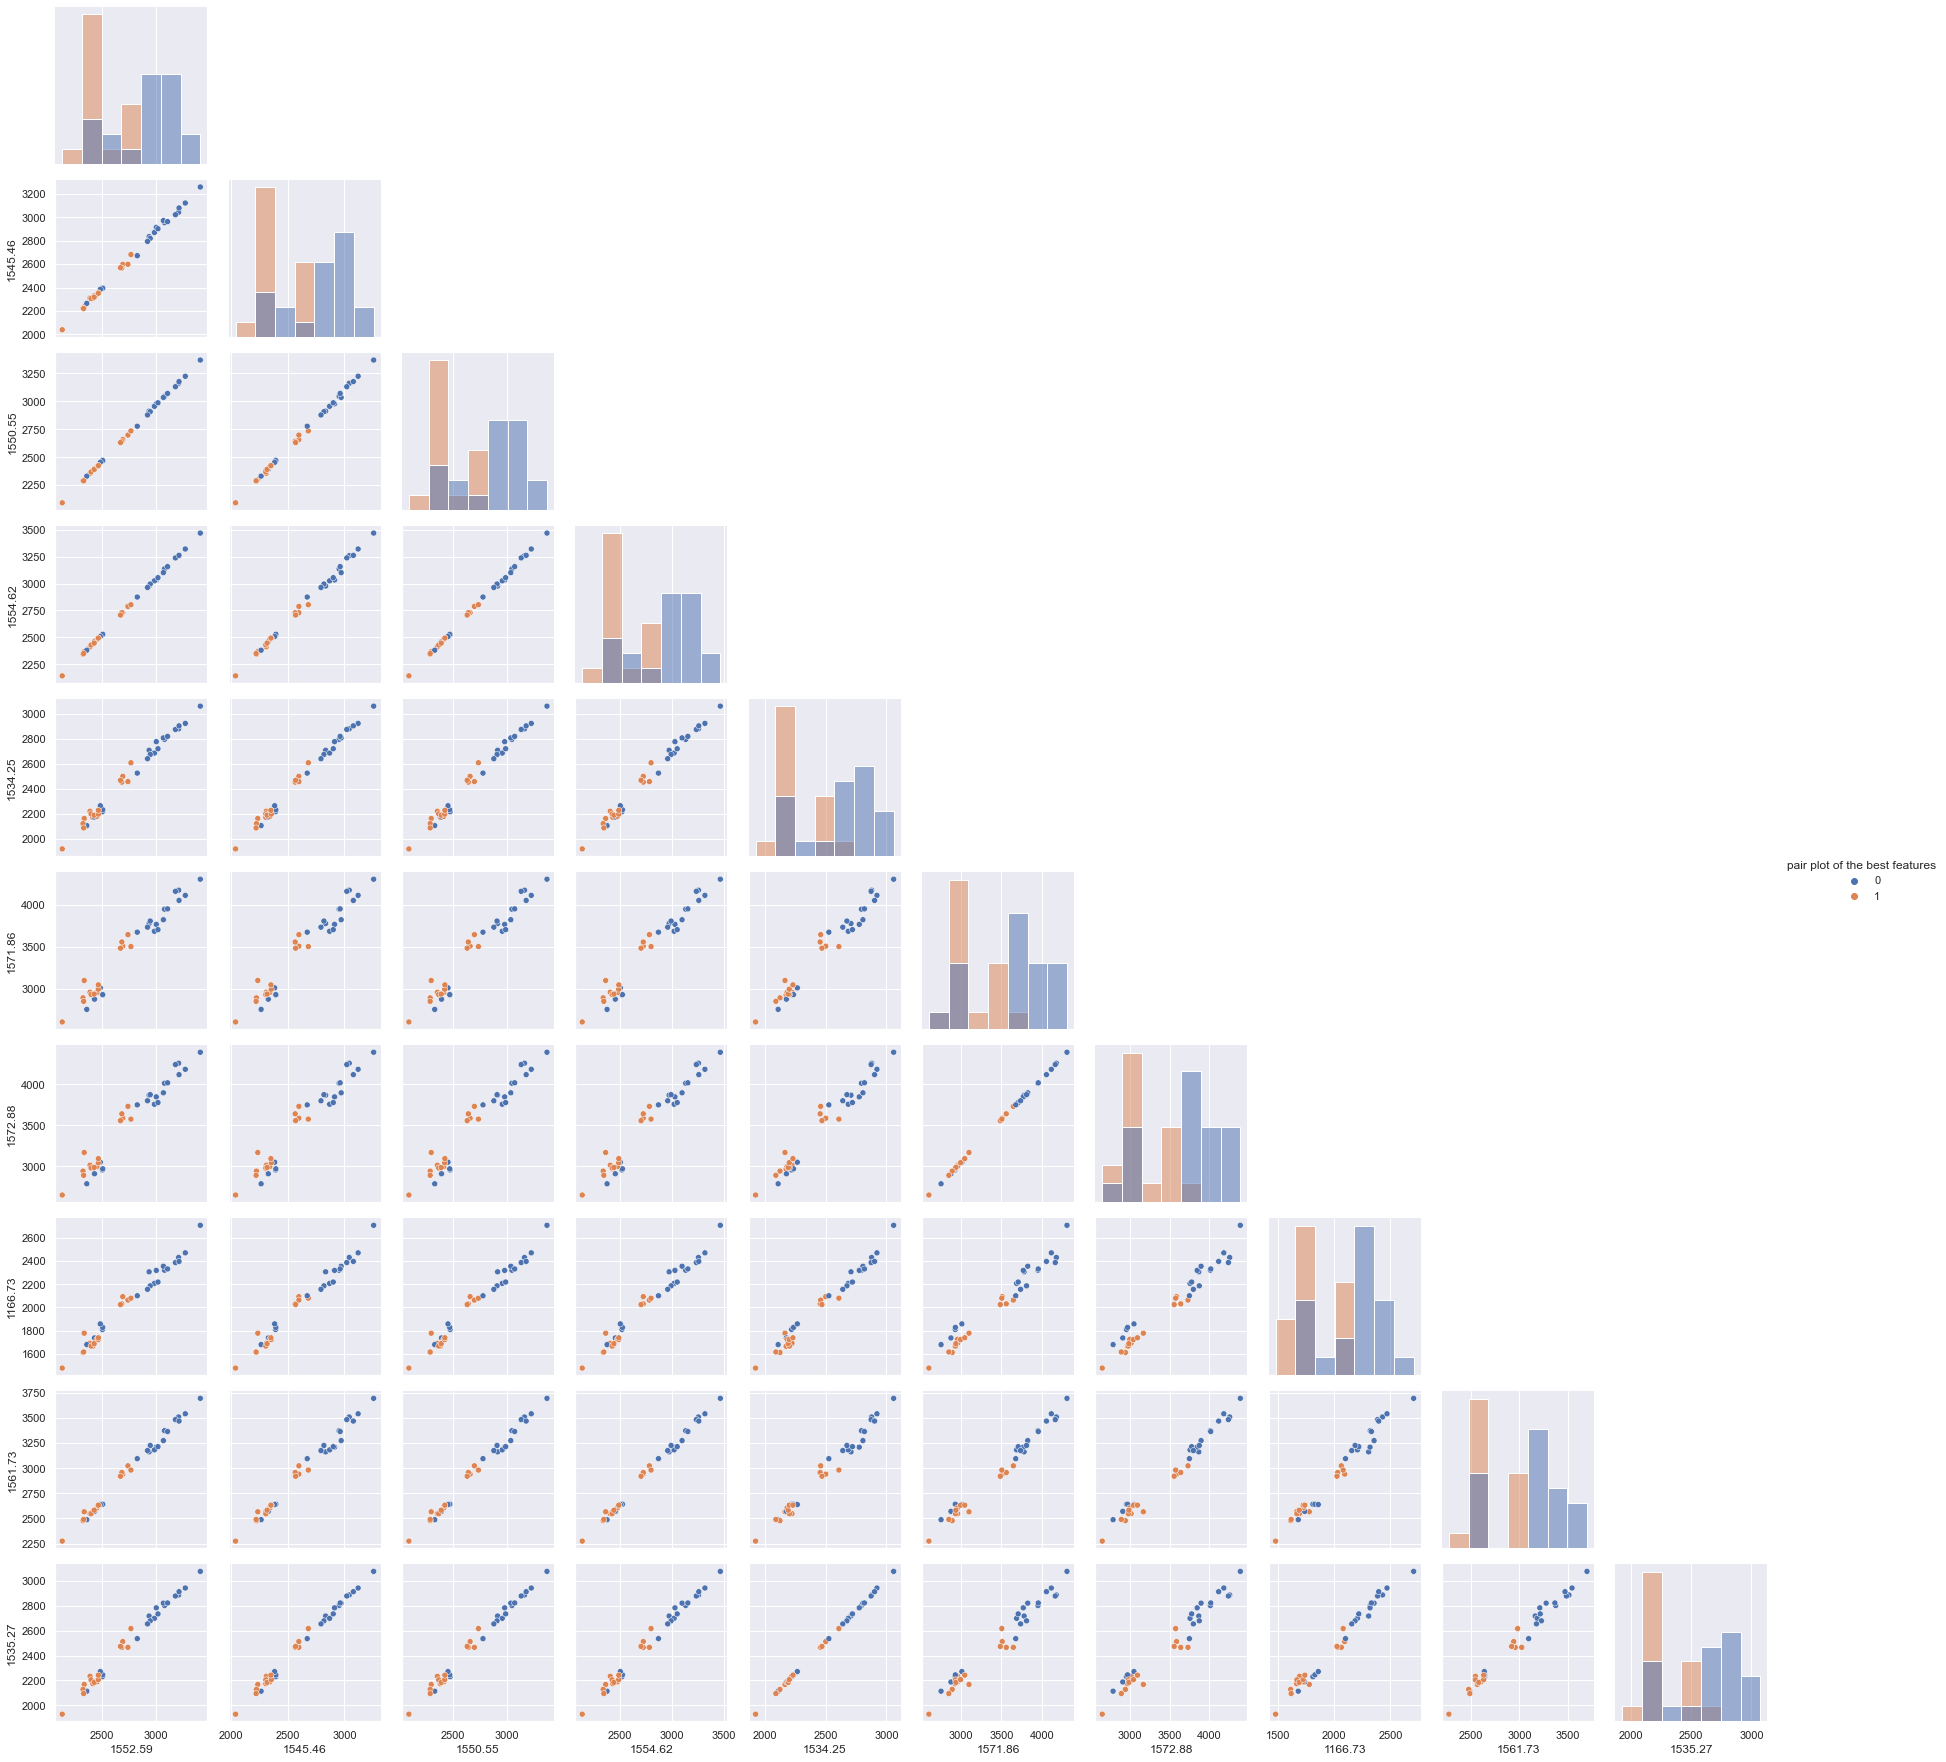

In [40]:
def pairPlot(data, hue):
    plot = sns.PairGrid(data, hue= hue, diag_sharey=False, corner=True)
    plot.map_lower(sns.scatterplot)
    plot.map_diag(sns.histplot)
    plot.add_legend(title="pair plot of the best features")
    plt.show()

pairPlot(k_best_df, 'target')

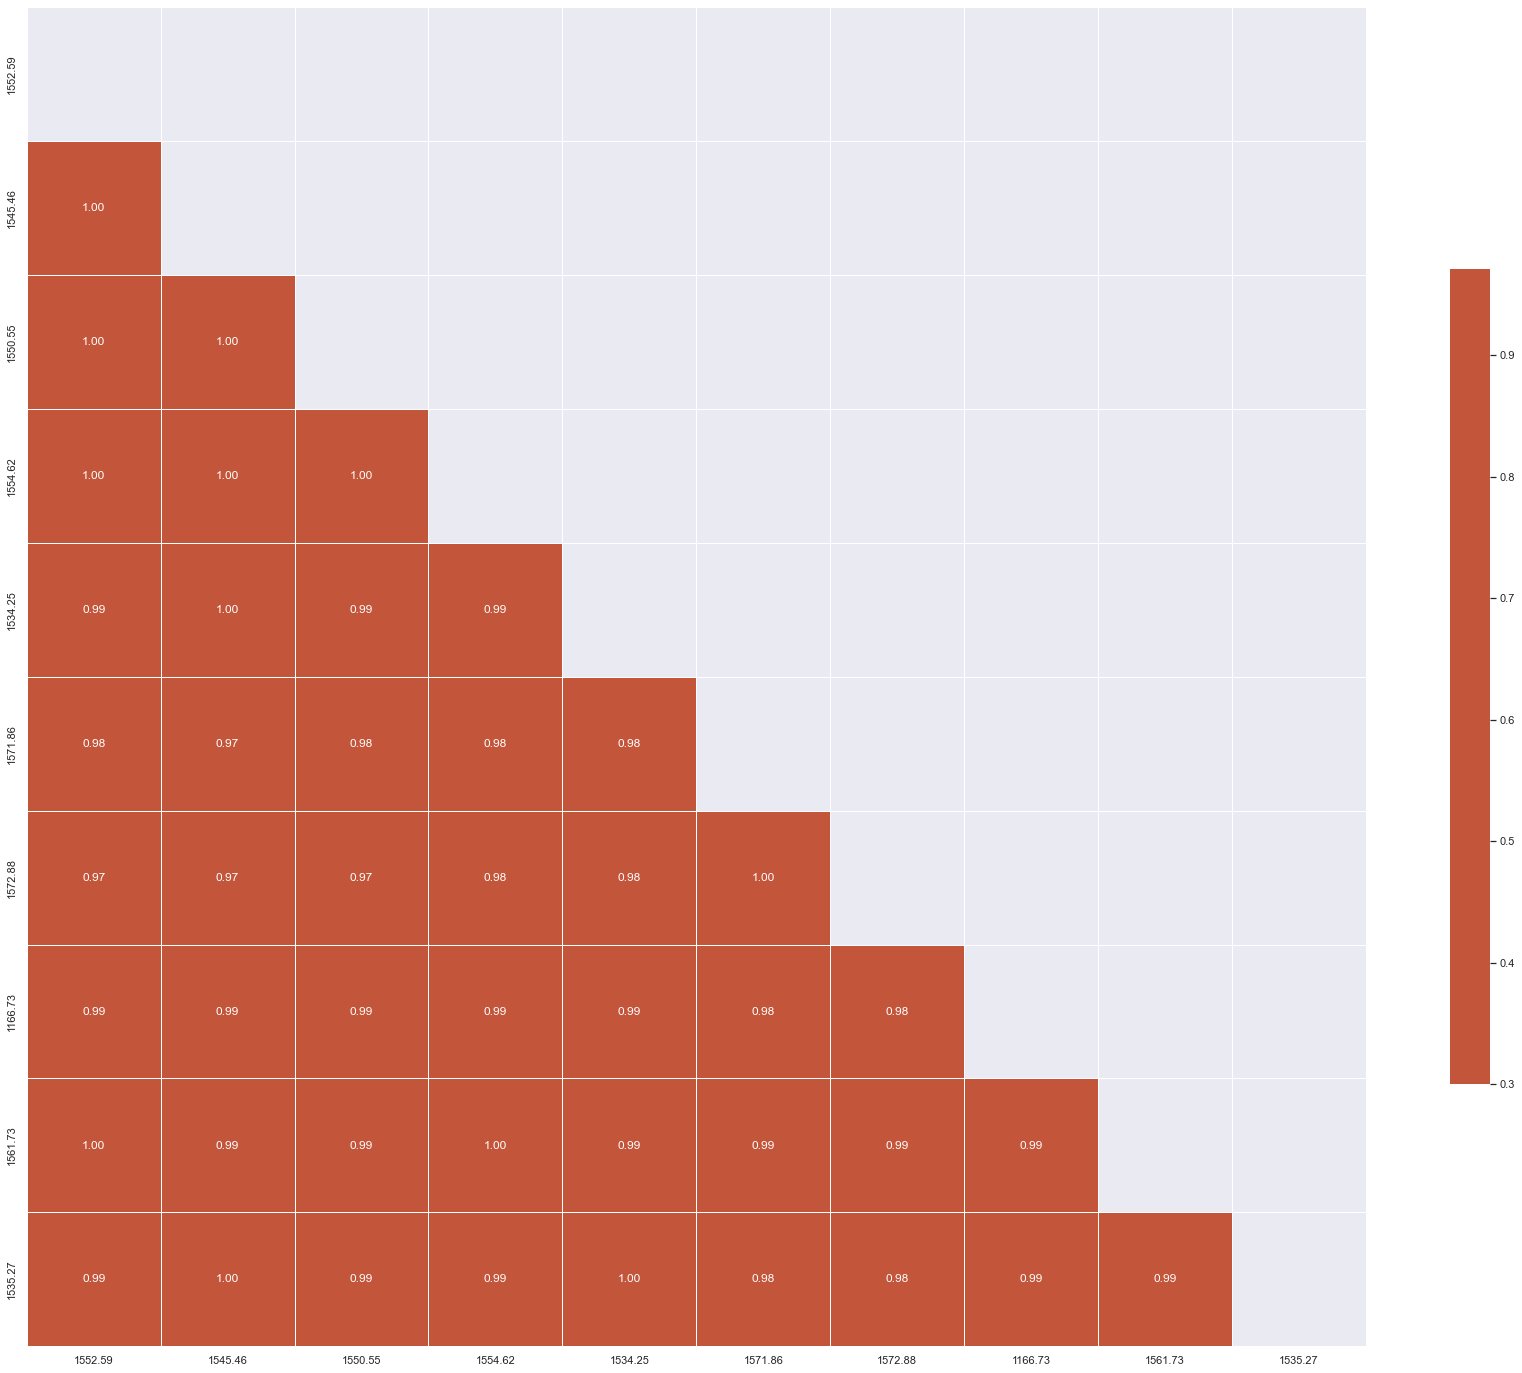

In [41]:
def correlationPlot(data):
    fig, ax = plt.subplots(figsize=(30, 30))
    corrMatrix = data.corr(method = 'pearson')
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                fmt = '.2f', annot = True)

    plt.show()


correlationPlot(k_best_df.iloc[:,:-1])

## Histogram of the features

In [42]:
from plotly.subplots import make_subplots

def histPlot(df, hue):
    n_cols = 2  # Number of columns
    n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Number of rows

    # Create a color map for each unique value in the "hue" column
    hue_colors = px.colors.qualitative.Plotly[:len(df[hue].unique())]
    color_map = dict(zip(df[hue].unique(), hue_colors))

    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns)

    for i, col in enumerate(df.columns):
        row_num = (i // n_cols) + 1
        col_num = (i % n_cols) + 1

        for hue_value in df[hue].unique():
            histogram_trace = go.Histogram(x=df[col][df[hue] == hue_value], nbinsx=30, opacity=0.7,
                                           marker_color=color_map[hue_value],
                                           name=f'{col} ({hue_value})', legendgroup=f'{col}')
            fig.add_trace(histogram_trace, row=row_num, col=col_num)

    fig.update_layout(title='Histograms for Each Column', height=300*n_rows)
    fig.update_xaxes(title_text='Value')
    fig.update_yaxes(title_text='Frequency', row=1, col=1)
    fig.show()


# X_bf = k_best_df.iloc[:,:-1]
histPlot(k_best_df, 'target')
# boxPlot(k_best_df, 'target')

In [43]:
# def boxPlot(df, hue):
#     n_cols = 2  # Number of columns
#     n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Number of rows

#     # Create a color map for each unique value in the "hue" column
#     hue_colors = px.colors.qualitative.Plotly[:len(df[hue].unique())]
#     color_map = dict(zip(df[hue].unique(), hue_colors))

#     fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns)

#     for i, col in enumerate(df.columns):
#         row_num = (i // n_cols) + 1
#         col_num = (i % n_cols) + 1

#         for hue_value in df[hue].unique():
#             box_trace = px.box(df[df[hue] == hue_value], x=hue, y=col, color=hue, title=f'Boxplot of {col}',
#                                boxmode='group', points='all', color_discrete_map={hue: color_map[hue_value]})
#             fig.add_trace(box_trace.data[0], row=row_num, col=col_num)

#     fig.update_layout(height=500*n_rows)
#     fig.show()

def boxPlot(df, hue):
    n_cols = 2  # Number of columns
    n_rows = (len(df.columns) + n_cols - 1) // n_cols  # Number of rows

    # Create a color map for each unique value in the "hue" column
    hue_colors = px.colors.qualitative.Plotly[:len(df[hue].unique())]
    color_map = dict(zip(df[hue].unique(), hue_colors))

    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=df.columns)

    for i, col in enumerate(df.columns):
        row_num = (i // n_cols) + 1
        col_num = (i % n_cols) + 1

        for hue_value in df[hue].unique():
            box_trace = px.box(df[df[hue] == hue_value], x=hue, y=col, color=hue,
                               title=f'Boxplot of {col} ({hue_value})', boxmode='group')
            box_trace.update_traces(marker_color=color_map[hue_value], boxpoints=False)  # Set color for each box trace
            fig.add_trace(box_trace.data[0], row=row_num, col=col_num)

    fig.update_layout(height=500*n_rows)
    fig.show()

boxPlot(k_best_df, 'target')

In [44]:
# def groupMaps(df):
#     # Group the data by the "map" and "target" columns and calculate the sum of each group divided by 441
#     grouped_df = df.groupby(['map', 'target']).sum() / 441

#     # Reset the index of the grouped DataFrame to make "map" a regular column
#     grouped_df = grouped_df.reset_index()

#     return grouped_df


# def groupMaps(df):
#     # Group the data by the "map" and "target" columns and calculate the sum of each group divided by 441
#     grouped_df = df.groupby(['map', 'target']).median()

#     # Reset the index of the grouped DataFrame to make "map" a regular column
#     grouped_df = grouped_df.reset_index()

#     return grouped_df

# X = raw_data.drop(['x','y','spec_number'], axis = 1)
# map_data = groupMaps(X)
# map_data.head()

In [45]:

# def plotSersSignal(dataframe):
#     sns.set(style="darkgrid")
#     fig, ax = plt.subplots(figsize=(16,12))

#     target_column = "target"
#     columns = dataframe.columns.to_list()
#     columns.remove(target_column)

#     dataframe_melted = dataframe.melt(id_vars=target_column, value_vars=columns, var_name="Wavelength (1/cm)", value_name="Intensity (u.a.)")
#     sns.lineplot(data=dataframe_melted, x="Wavelength (1/cm)", y="Intensity (u.a.)", hue=target_column, markers=True)

#     plt.xlabel('Wavelength (1/cm)')
#     plt.ylabel('Intensity (u.a.)')
#     plt.title('SERS Signal')
#     plt.legend()
#     plt.xticks(rotation=45)  # Set x-axis ticks to go from 50 to 50 values
#     #plt.tight_layout()
#     plt.show()


# X2 = map_data.drop(['map'], axis = 1)
# plotSersSignal(X2)


# Clustering

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



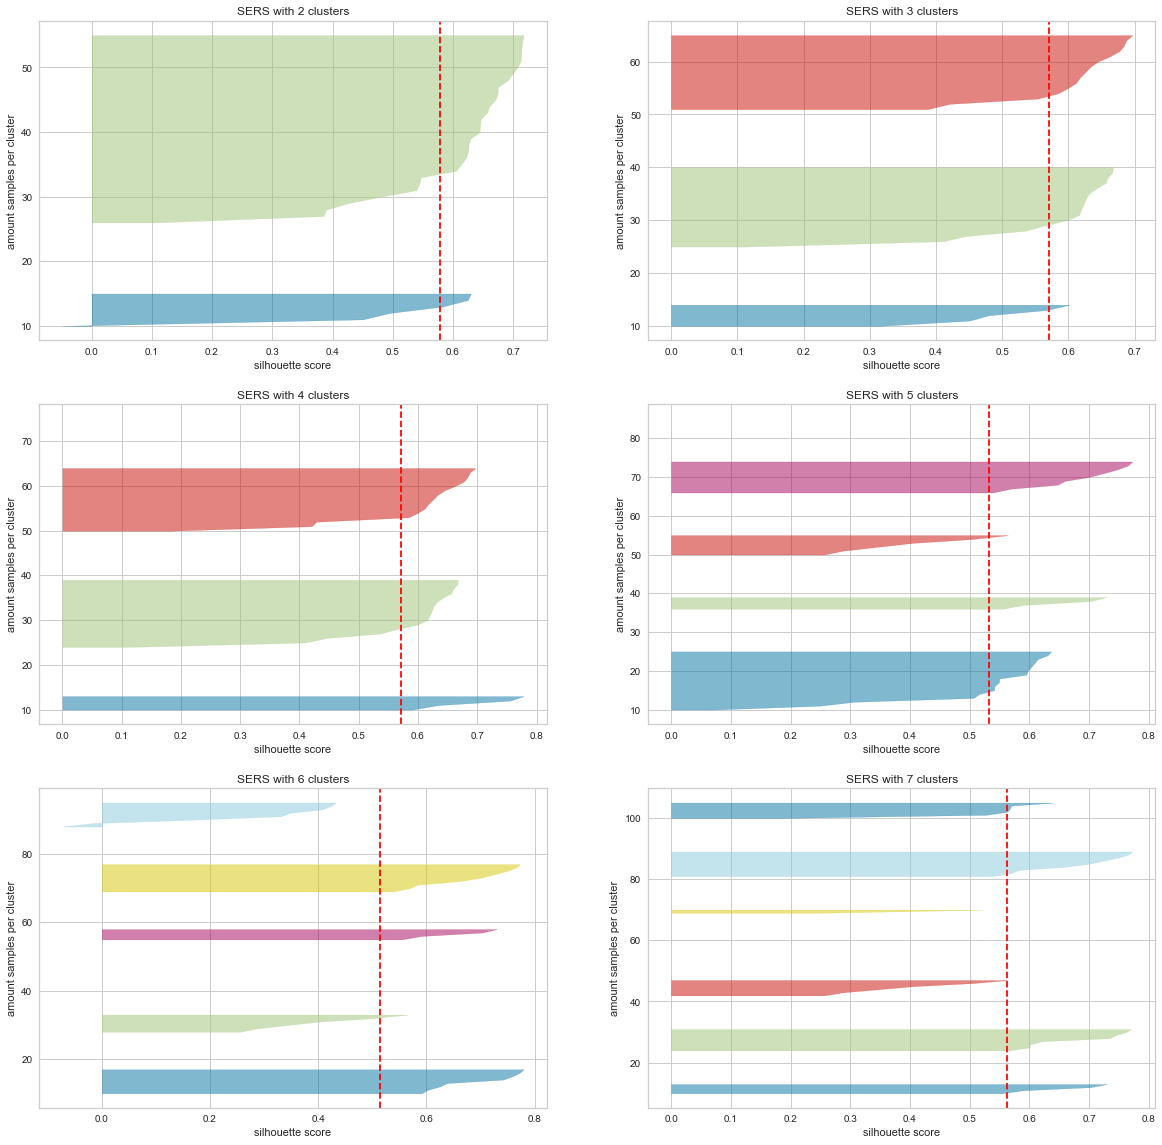

In [46]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine

def plotSilhoetteVisualizer(X, Ks, title):
    fig, ax = plt.subplots(3, 2, figsize = (20, 20))

    silhouette_coef_list = []
    for k in Ks:
        np.random.seed(42)
        km_model = KMeans(n_clusters = k)
        q, mod = divmod(k,2)
        dist_matrix = pairwise_distances(X, metric='cosine')

        visualizer = SilhouetteVisualizer(km_model, colors = 'yellowbrick', ax = ax[q-1][mod])

        ax[q-1][mod].set(title = f'{title} with {k} clusters', 
                         xlabel = 'silhouette score', 
                         ylabel = 'amount samples per cluster')
        
        visualizer.fit(dist_matrix)
        #print(f"{sensorName}: the silhouette's score for {k} clusters is {visualizer.silhouette_score_}")
        silhouette_coef_list.append(visualizer.silhouette_score_)
    plt.show()
    return silhouette_coef_list

## tentar fazer isso com mapas ao inves de espectros

Ks = [2,3,4,5,6,7]
# X = raw_data.drop(['x','y','spec_number','map', 'target'], axis = 1)
#X2 = X2.drop(['target'], axis = 1)

raw_silhouette_scores = plotSilhoetteVisualizer(X_map, Ks, 'SERS')

In [47]:
def plot_silhouette_score(silhouette_scores, Ks):
    fig = px.line(x=Ks, y=silhouette_scores, labels={'x': 'K cluster', 'y': "silhouette's score"})
    fig.update_traces(line_color='red')
    fig.update_layout(title="Comparison between the variation of silhouette's score with K cluster",
                      xaxis_title="K cluster", yaxis_title="silhouette's score",
                      width=800, height=600)
    fig.show()

plot_silhouette_score(raw_silhouette_scores, Ks)


# Classification

In [48]:
from sklearn.linear_model import LogisticRegression
import time

from sklearn.svm import SVC
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def mergeDataframes(df1, df2):
    mergedDf = pd.concat([df1, df2], axis = 1)
    return mergedDf

def separateFeatures(X, catVariables):
    numVariables = X.drop(catVariables, axis = 1).columns
    return catVariables, numVariables

def removeUselessColumns(df, columns):
    new_df = df.drop(columns, axis = 1)
    return new_df


def createBaselineModels(preprocessor):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'XGBoost': XGBClassifier(),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(),
    }

    for model_name in models:
        models[model_name] = Pipeline([
            ('preprocessor', preprocessor),
            ('model', models[model_name])
        ])

    return models

def createGridModels(modelsPipeline):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'XGBoost': XGBClassifier(),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(),
    }

    param_grids = {
        'Logistic Regression': {
            # 'model__C': np.logspace(-4, 4, 20),
            # 'model__solver': ['liblinear'],
            # 'model__penalty': ['l1', 'l2'],
        },
        'Random Forest': {
            # 'model__n_estimators': [1000,1500,2000],
            # 'model__max_depth': [10, 50, 100],
            # 'model__min_samples_split': [2, 5, 10],
            # 'model__min_samples_leaf': [1, 2, 4],
        },
        'KNN': {
            # 'model__n_neighbors': [10, 15, 20, 25],
            # 'model__metric': ['euclidean', 'manhattan'],
            # 'model__weights': ['uniform', 'distance'],
            # 'model__leaf_size': [20, 30, 50]
        },
        'XGBoost': {
            # 'model__n_estimators': [500, 1000, 1500],
            # 'model__max_depth': [3, 4, 5],
            # 'model__learning_rate': [0.1, 0.01],
            # 'model__subsample': [0.6, 0.8, 1.0],
        },
        'Naive Bayes': {
            'model__var_smoothing': np.logspace(0, -9, num=100)
        },
        'Decision Tree': {
            # 'model__max_depth': [3, 5, 10],
            # 'model__min_samples_leaf': [20, 50, 100],
            # 'model__criterion': ["gini", "entropy"],
            # 'model__min_samples_split': [2, 5, 10]


        },
    }

    for model_name in models:
        models[model_name] = GridSearchCV(models_pipeline[model_name], param_grids[model_name], n_jobs=-1)

    return models



def createModels(preprocessor, withGrid):
    np.random.seed(42)

    modelsPipeline = createBaselineModels(preprocessor)

    if withGrid:
        modelsGrid = createGridModels(modelsPipeline)
        return modelsGrid

    return modelsPipeline

        


def preprocessingData(cat_features, num_features, scaler, encoder):
    ## Tratamento para variáveis categóricas
    cat_transformer = Pipeline(steps = [
        ('encoder', encoder)
    ])

    ## Tratamento para variáveis numéricas
    num_transformer = Pipeline(steps = [
        ('scaler', scaler)
    ])

    ## Transformando os dados
    preprocessor = ColumnTransformer(transformers = [
        ('numbers', num_transformer, num_features),
        ('categories', cat_transformer, cat_features)
    ])

    ## Retornando o processador de dados
    return preprocessor

def format_metrics(scores):
    avg = round(np.mean(scores), 2)
    std = round(np.std(scores), 2)
    return f'{str(avg)} ({str(std)})'


def trainModels(X, y, models, skf):
    scoring = ('accuracy', 'precision', 'recall', 'f1')
    models_scores = {}

    for modelName, model in models.items():
        startTime = time.time()
        scores = cross_validate(model, X, y, cv=skf, scoring=scoring)

        cross_metrics = {
            'accuracy': format_metrics(scores['test_accuracy']),
            'precision': format_metrics(scores['test_precision']),
            'recall': format_metrics(scores['test_recall']),
            'f1': format_metrics(scores['test_f1'])
        }

        models_scores[modelName] = cross_metrics

        endTime = time.time()
        print(f'{modelName}: {round(endTime - startTime, 2)} seconds')

    return models_scores


def runModels(X, y, catFeatures, numFeatures, scaler, encoder, withGrid=False):
    preprocessor = preprocessingData(cat_features=catFeatures, num_features=numFeatures, scaler=scaler, encoder=encoder)
    models = createModels(preprocessor, withGrid)
    skf = StratifiedKFold(n_splits=5)
    models_scores = trainModels(X, y, models, skf)
    
    models_scores = pd.DataFrame(models_scores)
    # models_acc = models_scores.loc['accuracy'].values
    models_names = models.keys()

    return models_scores, models_names


def dataPipeline(data, noUsedColumns = ['x','y', 'spec_number', 'map','target']):

    #print(f'---{dataName} started---', end='\n\n')
    startTime = time.time()
    new_data = data.copy()
    X, y = splitData(data, noUsedColumns, 'target')
    catFeatures, numFeatures = separateFeatures(X, [])
    models_metrics, models_names = runModels(
        X, y, catFeatures, numFeatures, StandardScaler(), OneHotEncoder(handle_unknown='ignore')
    )

    endTime = time.time()
    #print(f'\n---{dataName}: completed in {round(endTime - startTime, 2)} seconds---', end='\n\n')

    return models_metrics.T

def convertComplexToReal(df):
    for column in df.columns:
        if df[column].dtype == np.complex128:
            df[column] = df[column].apply(lambda x: x.real)
    return df


def treatFFTData(dfs):
    newFFT = {}
    for dfName, df in dfs.items():
        new_df = df.iloc[:,:-1].copy()
        new_df = convertComplexToReal(new_df)
        newFFT[dfName] = new_df
        newFFT[dfName]['target'] = df['target']
    return newFFT


In [49]:
raw_data.columns

Index([      1611.19,       1610.19,       1609.18,       1608.18,
             1607.17,       1606.17,       1605.16,       1604.16,
             1603.15,       1602.14,
       ...
             476.105,        474.84,       473.574,       472.308,
             471.042,           'x',           'y', 'spec_number',
               'map',      'target'],
      dtype='object', length=1019)

In [50]:
map_metrics = dataPipeline(map_data, noUsedColumns=['target', 'map'])
map_metrics

Logistic Regression: 0.7 seconds
Random Forest: 2.47 seconds
KNN: 0.56 seconds
XGBoost: 3.82 seconds
Naive Bayes: 0.53 seconds
Decision Tree: 0.27 seconds


accuracy    precision       recall           f1
Logistic Regression  0.86 (0.22)  0.89 (0.23)  0.93 (0.13)  0.88 (0.16)
Random Forest        0.72 (0.18)  0.74 (0.23)  0.83 (0.21)  0.74 (0.14)
KNN                  0.63 (0.35)  0.62 (0.37)  0.75 (0.39)  0.65 (0.35)
XGBoost              0.75 (0.31)  0.74 (0.29)  0.82 (0.26)  0.76 (0.26)
Naive Bayes          0.72 (0.37)  0.73 (0.39)  0.68 (0.37)   0.7 (0.37)
Decision Tree        0.61 (0.25)  0.69 (0.28)  0.72 (0.28)  0.62 (0.21)

In [51]:
peak_metrics = dataPipeline(sampleMap, noUsedColumns=['target'])
peak_metrics

Logistic Regression: 0.12 seconds
Random Forest: 1.5 seconds
KNN: 0.1 seconds
XGBoost: 0.27 seconds
Naive Bayes: 0.12 seconds
Decision Tree: 0.09 seconds


accuracy    precision       recall           f1
Logistic Regression  0.66 (0.35)  0.68 (0.37)  0.63 (0.37)  0.64 (0.34)
Random Forest        0.64 (0.29)  0.74 (0.33)  0.65 (0.32)  0.62 (0.27)
KNN                  0.63 (0.37)  0.64 (0.38)  0.75 (0.39)  0.66 (0.36)
XGBoost              0.61 (0.34)  0.63 (0.37)  0.63 (0.37)  0.61 (0.34)
Naive Bayes          0.72 (0.37)  0.73 (0.39)  0.68 (0.37)   0.7 (0.37)
Decision Tree        0.69 (0.25)  0.77 (0.29)   0.77 (0.2)  0.72 (0.18)

In [52]:
best_features_map_metrics = dataPipeline(k_best_df, noUsedColumns=['target'])
best_features_map_metrics

Logistic Regression: 0.12 seconds
Random Forest: 2.65 seconds
KNN: 0.18 seconds
XGBoost: 0.4 seconds
Naive Bayes: 0.28 seconds
Decision Tree: 0.26 seconds


accuracy    precision       recall           f1
Logistic Regression  0.75 (0.32)  0.77 (0.31)  0.75 (0.25)  0.75 (0.28)
Random Forest         0.8 (0.19)  0.79 (0.21)  0.93 (0.13)  0.82 (0.13)
KNN                  0.74 (0.39)  0.73 (0.39)  0.73 (0.39)  0.73 (0.39)
XGBoost               0.8 (0.21)  0.77 (0.22)  0.93 (0.13)  0.82 (0.17)
Naive Bayes          0.75 (0.32)  0.77 (0.31)  0.75 (0.25)  0.75 (0.28)
Decision Tree        0.83 (0.11)  0.79 (0.18)   0.95 (0.1)  0.84 (0.09)

In [53]:
X2.columns

Index([ 1611.19,  1610.19,  1609.18,  1608.18,  1607.17,  1606.17,  1605.16,
        1604.16,  1603.15,  1602.14,
       ...
        481.162,  479.898,  478.634,   477.37,  476.105,   474.84,  473.574,
        472.308,  471.042, 'target'],
      dtype='object', length=1015)

# PCA

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


def calculate_pca(df, n_components=None, scaler=None):
    X = df.drop(['target'], axis=1)

    if scaler is not None:
        X = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    new_df = pd.DataFrame(principal_components)
    new_df['target'] = df['target'].values

    return pca, new_df


def plot_pca_variance(pca, name_sensor, scaler_name=None):
    features = np.arange(pca.n_components_)
    explained_variance_ratio = pca.explained_variance_ratio_

    fig = go.Figure(data=go.Bar(x=features, y=explained_variance_ratio))

    fig.update_layout(
        xaxis=dict(title='PCA features', tickvals=features, ticktext=[str(i) for i in features]),
        yaxis=dict(title='variance %'),
        title=f'{name_sensor} with {scaler_name} scaler',
        height=600,
        width=800,
    )

    fig.show()


def calculating_pca(df, name_sensor, n_components, scaler=None):
    pca, new_df = calculate_pca(df, n_components, scaler)
    plot_pca_variance(pca, name_sensor, scaler.__class__.__name__)

    return new_df

def convertColsNameToStr(df):
    """
    Convert column names in a Pandas DataFrame to string data type.
    """
    df.columns = df.columns.astype(str)
    return df


map_data = convertColsNameToStr(map_data)
# print(X_map.columns)
PCA_components = calculating_pca(map_data, "PCA from SERS's map", 10)


In [55]:
#PCA_components

In [56]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def plotPCA(df, title, target='target', color_map={}):
    fig = px.scatter(df, x=0, y=1, color=df[target], color_continuous_scale=list(color_map.values()))
    fig.update_layout(title=title, xaxis_title='PC1', yaxis_title='PC2')
    fig.show()


    
custom_color_map = {0: 'blue', 1: 'red'}

plotPCA(df = PCA_components, 
        title = "SERS's sensor - PCA components",
        color_map = custom_color_map
        )

## Cluster Analysis

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



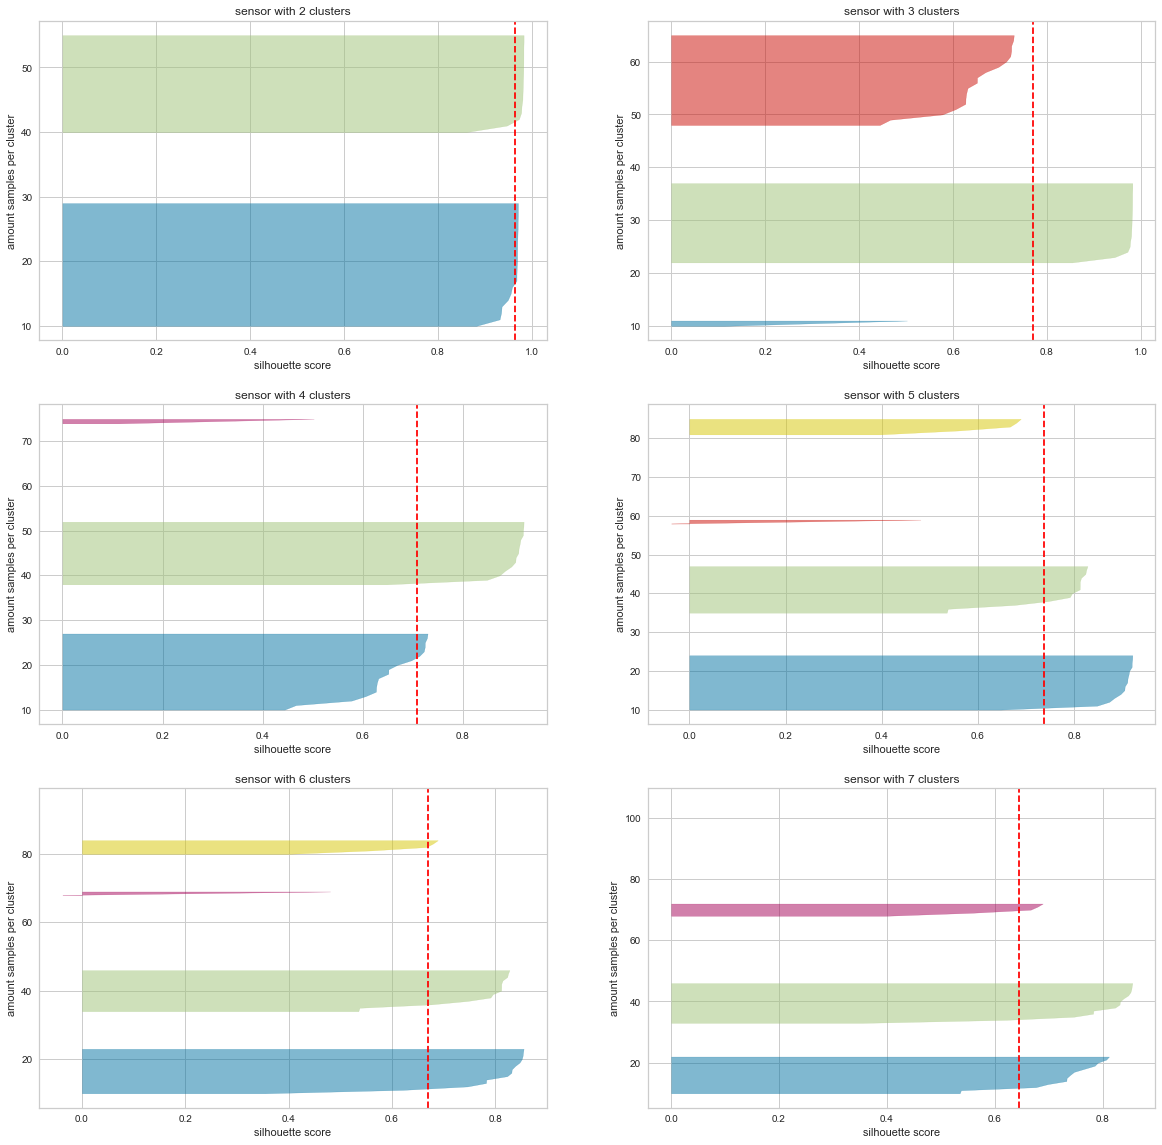

In [57]:
Ks = [2,3,4,5,6,7]
pca_silhouette_scores = plotSilhoetteVisualizer(X = PCA_components.iloc[:,:2], 
                                                Ks = Ks, 
                                                title='sensor')



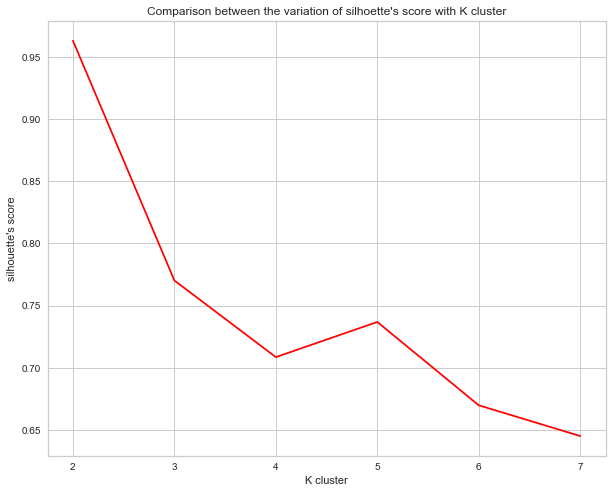

In [58]:

def plot_silhouette_score(silhouette_scores, Ks):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))
    sns.lineplot(x=Ks, y = silhouette_scores, color = 'red', ax=ax)
    ax.set(title = "Comparison between the variation of silhoette's score with K cluster",
           xlabel = 'K cluster',
           ylabel = "silhouette's score"
    )

    plt.show()

plot_silhouette_score(pca_silhouette_scores, Ks)

In [59]:
def clusterPreds(X, k):
    #print(X.columns, k)
    kmeans = KMeans(n_clusters = k)
    cluster_pred = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    return cluster_pred, centroids

def getMaxSilhouetteScore(array):
    return max(array)

def getIndexArray(array, value):
    return array.index(value)

def getBestK(array, Ks):
    max_silhouette = getMaxSilhouetteScore(array)
    k_position = getIndexArray(array, max_silhouette)
    k = Ks[k_position]
    return k


best_K_sensor = getBestK(pca_silhouette_scores, Ks)
PCA_components['clusterPred'], pcaCentroidSensor = clusterPreds(
                                                    X = PCA_components.iloc[:, :2],
                                                    k = best_K_sensor
                                                )


plotPCA(df = PCA_components, 
        title = f'{best_K_sensor} clusters',
        target = 'clusterPred',
        color_map = custom_color_map
        )

# plotPCA(df = PCA_components,
#         target = 'clusterPred',
#         title = 'sensor', 
#         ax = ax[1]
#         )


# plotDecisionBoundaries(df = PCA_components,
#                        target = 'target',
#                        labels = PCA_components['clusterPred'],
#                        centroids = pcaCentroidSensor,
#                        title = f"{best_K_sensor} clusters in sensor",
#                        ax = ax[1])


# plt.show()

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [60]:
PCA_components.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'target', 'clusterPred'], dtype='object')

## classification

In [61]:
pca_metrics = dataPipeline(PCA_components, noUsedColumns=['target', 'clusterPred'])
pca_metrics

Logistic Regression: 0.14 seconds
Random Forest: 1.82 seconds
KNN: 0.12 seconds
XGBoost: 0.55 seconds
Naive Bayes: 0.16 seconds
Decision Tree: 0.16 seconds


accuracy    precision       recall           f1
Logistic Regression  0.91 (0.11)  0.88 (0.15)  0.93 (0.13)   0.9 (0.13)
Random Forest        0.77 (0.15)  0.74 (0.22)   0.8 (0.27)  0.74 (0.19)
KNN                  0.71 (0.18)  0.65 (0.19)    1.0 (0.0)  0.77 (0.13)
XGBoost              0.66 (0.37)    0.7 (0.4)  0.67 (0.42)  0.63 (0.37)
Naive Bayes           0.8 (0.26)  0.87 (0.27)   0.8 (0.16)   0.81 (0.2)
Decision Tree        0.66 (0.37)    0.7 (0.4)  0.67 (0.42)  0.63 (0.37)

# FFT

In [62]:
# The given calculatingFFT function (unchanged)
def calculatingFFT(dataset):
    # Calculate the sampling rate and time spacing
    sampling_rate = 1 / (dataset.columns[1] - dataset.columns[0])
    time_spacing = dataset.columns[1] - dataset.columns[0]

    # Calculate the Fourier transform for each signal
    transforms = []
    frequencies = np.fft.fftfreq(len(dataset.columns), time_spacing)
    indices = np.argsort(frequencies)

    for i in range(len(dataset)):
        current = dataset.iloc[i].values
        transform = np.fft.fft(current)
        transforms.append(np.abs(transform[indices]))

    # Create a new dataset with the Fourier transforms and corresponding frequencies
    new_dataset = pd.DataFrame(transforms, columns=np.around(frequencies[indices], decimals=3))
    return new_dataset

# The given convert_column_names_to_float function (unchanged)
def convert_column_names_to_float(df, epsilon=1e-9):
    converted_columns = [float(col) + epsilon for col in df.columns]
    df.columns = converted_columns
    return df

def find_non_unique_columns(df):
    # Count the occurrences of each column name in the DataFrame
    column_counts = df.columns.value_counts()
    
    # Find the column names that are not unique
    non_unique_columns = column_counts[column_counts > 1].index.tolist()
    
    return non_unique_columns


X_map = map_data.iloc[:,2:]
X_map_converted = convert_column_names_to_float(X_map)
fft_data = calculatingFFT(X_map)
fft_data['target'] = map_data['target']
fft_data.head()

-0.499      -0.498      -0.497      -0.496      -0.495      -0.494  \
0  793.296544  679.677228  741.558753  638.326419  862.974624  532.142921   
1  587.657516  561.886809  642.298004  547.845403  680.063737  615.807471   
2  740.028514  685.487194  781.337473  616.081039  826.494371  616.285099   
3  613.638439  574.180762  581.336830  501.589167  611.124753  551.202248   
4  740.848025  692.770342  797.227522  654.913141  852.674305  598.721319   

       -0.493      -0.492      -0.491       -0.49  ...       0.492  \
0  752.344374  518.120047  685.357381  622.374928  ...  518.120047   
1  585.320016  439.737521  606.645827  590.376168  ...  439.737521   
2  748.378445  564.455998  649.477588  657.384929  ...  564.455998   
3  594.352155  484.471749  527.453797  546.581864  ...  484.471749   
4  651.178350  456.038596  686.220191  695.571335  ...  456.038596   

        0.493       0.494       0.495       0.496       0.497       0.498  \
0  752.344374  532.142921  862.974624  638.326419  741.558753  679.677228   
1  585.320016  615.807471  680.063737  547.845403  642.298004  561.886809   
2  748.378445  616.285099  826.494371  616.081039  781.337473  685.487194   
3  594.352155  551.202248  611.124753  501.589167  581.336830  574.180762   
4  651.178350  598.721319  852.674305  654.913141  797.227522  692.770342   

        0.499         0.5  target  
0  793.296544  493.564286       0  
1  587.657516  407.840034       1  
2  740.028514  537.092086       0  
3  613.638439  417.133825       1  
4  740.848025  563.507778       0  

[5 rows x 1015 columns]

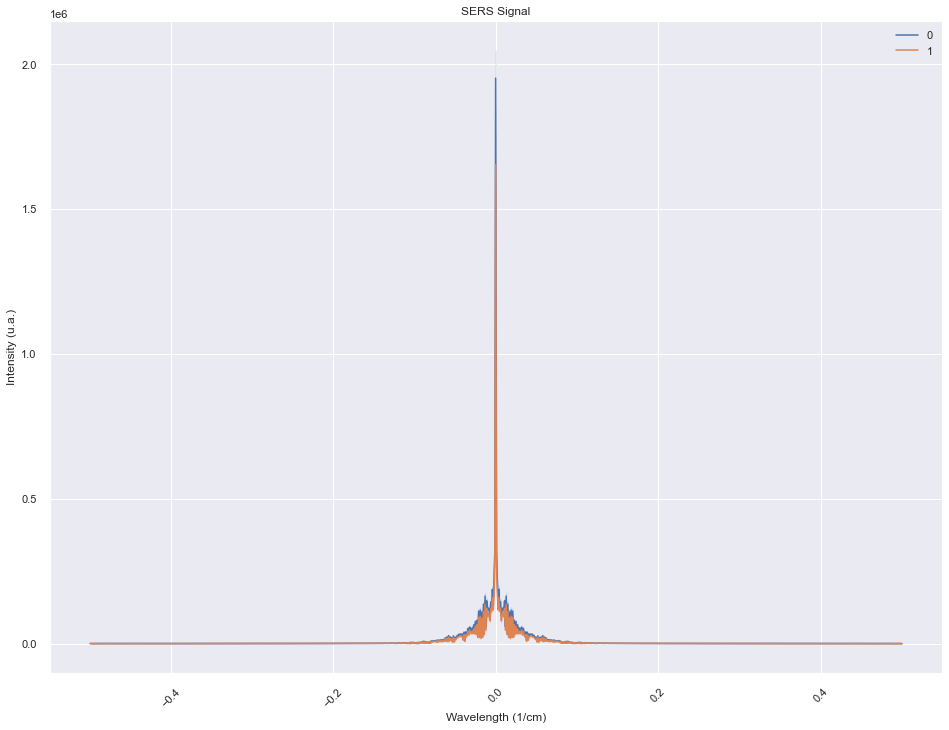

In [63]:
plotSersSignal(fft_data)

In [64]:
X_sensor, y_sensor = splitData(fft_data, ['target'], 'target')
MIF_sample_fft = estimatorScore(X_sensor, y_sensor, 'Feature Importance with mutual info classifier for fft', algorithm='mutual_info_classif')

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



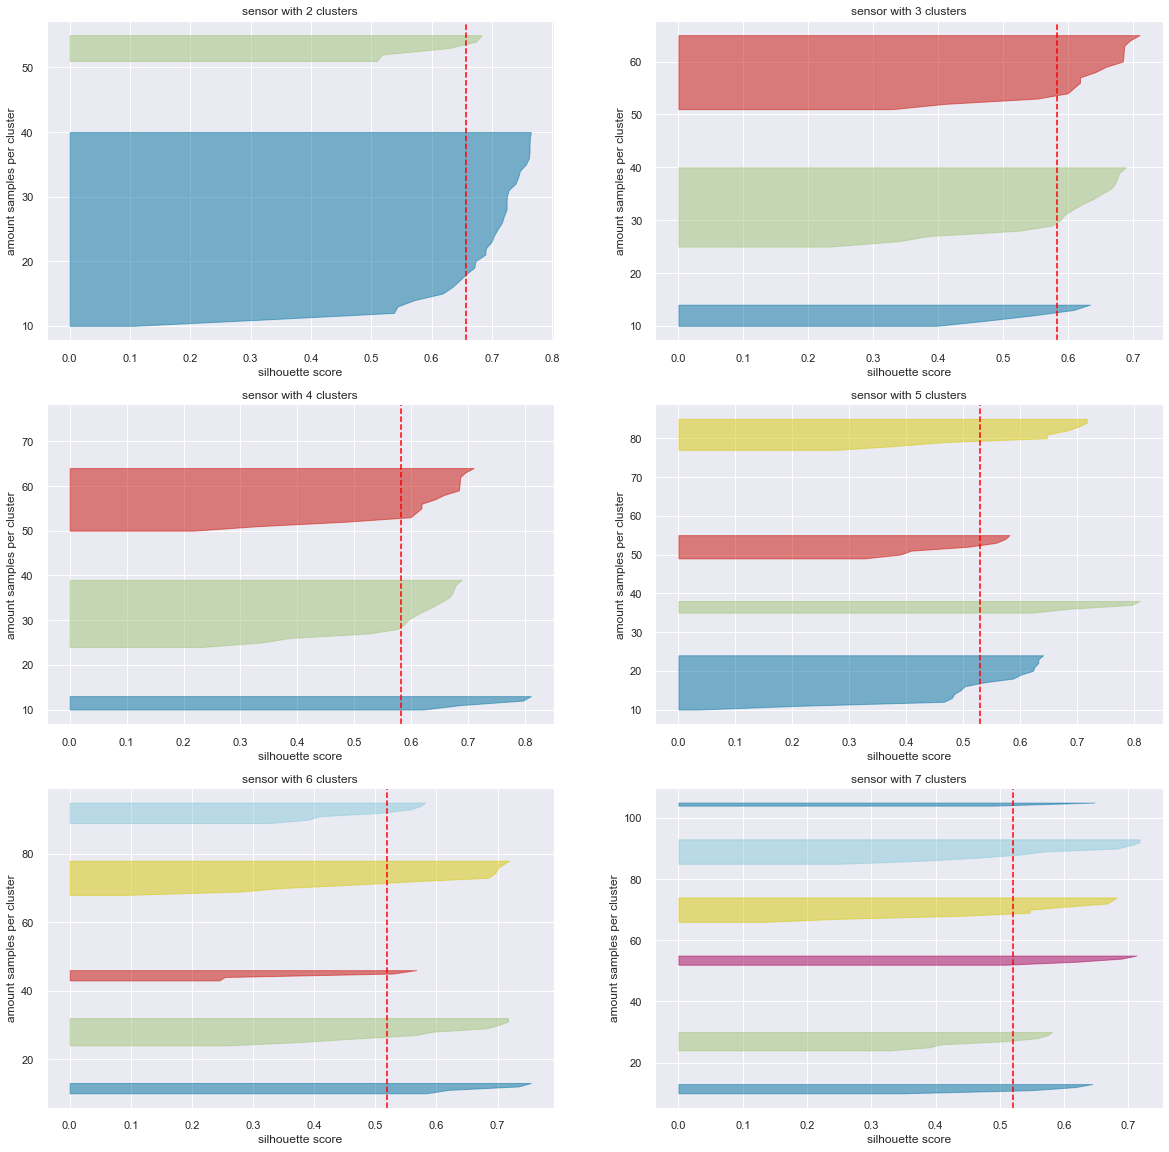

In [65]:
Ks = [2,3,4,5,6,7]
fft_silhouette_scores = plotSilhoetteVisualizer(X = fft_data, 
                                                Ks = Ks, 
                                                title='sensor')

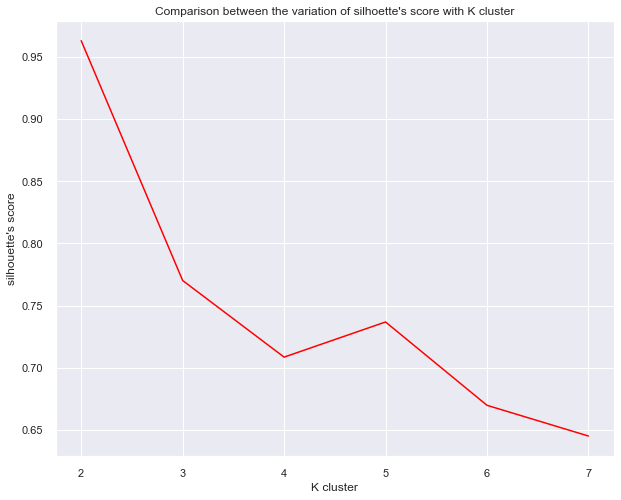

In [66]:
plot_silhouette_score(pca_silhouette_scores, Ks)

In [67]:
find_non_unique_columns(fft_data)

[0.179,
 -0.036,
 0.464,
 -0.107,
 -0.393,
 0.107,
 -0.321,
 0.036,
 0.393,
 0.321,
 -0.25,
 0.25,
 -0.179,
 -0.464]

In [68]:
fft_data[-0.464].head()

-0.464      -0.464
0  682.693306  710.135195
1  560.835898  563.762748
2  618.636671  664.514859
3  603.680047  580.039043
4  683.541581  684.399875

In [69]:

fft_metrics = dataPipeline(fft_data, noUsedColumns=['target'])
fft_metrics

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\compose\_column_transformer.py", line 723, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\compose\_column_transformer.py", line 425, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\__init__.py", line 450, in _get_column_indices
    raise ValueError(
ValueError: Selected columns, [-0.499, -0.498, -0.497, -0.496, -0.495, -0.494, -0.493, -0.492, -0.491, -0.49, -0.489, -0.488, -0.487, -0.486, -0.485, -0.484, -0.483, -0.482, -0.481, -0.48, -0.479, -0.478, -0.477, -0.476, -0.475, -0.474, -0.473, -0.472, -0.471, -0.47, -0.469, -0.468, -0.467, -0.466, -0.465, -0.464, -0.464, -0.463, -0.462, -0.461, -0.46, -0.459, -0.458, -0.457, -0.456, -0.455, -0.454, -0.453, -0.452, -0.451, -0.45, -0.449, -0.448, -0.447, -0.446, -0.445, -0.444, -0.443, -0.442, -0.441, -0.44, -0.439, -0.438, -0.437, -0.436, -0.435, -0.434, -0.433, -0.432, -0.431, -0.43, -0.429, -0.428, -0.427, -0.426, -0.425, -0.424, -0.423, -0.422, -0.421, -0.42, -0.419, -0.418, -0.417, -0.416, -0.415, -0.414, -0.413, -0.412, -0.411, -0.41, -0.409, -0.408, -0.407, -0.406, -0.405, -0.404, -0.403, -0.402, -0.401, -0.4, -0.399, -0.398, -0.397, -0.396, -0.395, -0.394, -0.393, -0.393, -0.392, -0.391, -0.39, -0.389, -0.388, -0.387, -0.386, -0.385, -0.384, -0.383, -0.382, -0.381, -0.38, -0.379, -0.378, -0.377, -0.376, -0.375, -0.374, -0.373, -0.372, -0.371, -0.37, -0.369, -0.368, -0.367, -0.366, -0.365, -0.364, -0.363, -0.362, -0.361, -0.36, -0.359, -0.358, -0.357, -0.356, -0.355, -0.354, -0.353, -0.352, -0.351, -0.35, -0.349, -0.348, -0.347, -0.346, -0.345, -0.344, -0.343, -0.342, -0.341, -0.34, -0.339, -0.338, -0.337, -0.336, -0.335, -0.334, -0.333, -0.332, -0.331, -0.33, -0.329, -0.328, -0.327, -0.326, -0.325, -0.324, -0.323, -0.322, -0.321, -0.321, -0.32, -0.319, -0.318, -0.317, -0.316, -0.315, -0.314, -0.313, -0.312, -0.311, -0.31, -0.309, -0.308, -0.307, -0.306, -0.305, -0.304, -0.303, -0.302, -0.301, -0.3, -0.299, -0.298, -0.297, -0.296, -0.295, -0.294, -0.293, -0.292, -0.291, -0.29, -0.289, -0.288, -0.287, -0.286, -0.285, -0.284, -0.283, -0.282, -0.281, -0.28, -0.279, -0.278, -0.277, -0.276, -0.275, -0.274, -0.273, -0.272, -0.271, -0.27, -0.269, -0.268, -0.267, -0.266, -0.265, -0.264, -0.263, -0.262, -0.261, -0.26, -0.259, -0.258, -0.257, -0.256, -0.255, -0.254, -0.253, -0.252, -0.251, -0.25, -0.25, -0.249, -0.248, -0.247, -0.246, -0.245, -0.244, -0.243, -0.242, -0.241, -0.24, -0.239, -0.238, -0.237, -0.236, -0.235, -0.234, -0.233, -0.232, -0.231, -0.23, -0.229, -0.228, -0.227, -0.226, -0.225, -0.224, -0.223, -0.222, -0.221, -0.22, -0.219, -0.218, -0.217, -0.216, -0.215, -0.214, -0.213, -0.212, -0.211, -0.21, -0.209, -0.208, -0.207, -0.206, -0.205, -0.204, -0.203, -0.202, -0.201, -0.2, -0.199, -0.198, -0.197, -0.196, -0.195, -0.194, -0.193, -0.192, -0.191, -0.19, -0.189, -0.188, -0.187, -0.186, -0.185, -0.184, -0.183, -0.182, -0.181, -0.18, -0.179, -0.179, -0.178, -0.177, -0.176, -0.175, -0.174, -0.173, -0.172, -0.171, -0.17, -0.169, -0.168, -0.167, -0.166, -0.165, -0.164, -0.163, -0.162, -0.161, -0.16, -0.159, -0.158, -0.157, -0.156, -0.155, -0.154, -0.153, -0.152, -0.151, -0.15, -0.149, -0.148, -0.147, -0.146, -0.145, -0.144, -0.143, -0.142, -0.141, -0.14, -0.139, -0.138, -0.137, -0.136, -0.135, -0.134, -0.133, -0.132, -0.131, -0.13, -0.129, -0.128, -0.127, -0.126, -0.125, -0.124, -0.123, -0.122, -0.121, -0.12, -0.119, -0.118, -0.117, -0.116, -0.115, -0.114, -0.113, -0.112, -0.111, -0.11, -0.109, -0.108, -0.107, -0.107, -0.106, -0.105, -0.104, -0.103, -0.102, -0.101, -0.1, -0.099, -0.098, -0.097, -0.096, -0.095, -0.094, -0.093, -0.092, -0.091, -0.09, -0.089, -0.088, -0.087, -0.086, -0.085, -0.084, -0.083, -0.082, -0.081, -0.08, -0.079, -0.078, -0.077, -0.076, -0.075, -0.074, -0.073, -0.072, -0.071, -0.07, -0.069, -0.068, -0.067, -0.066, -0.065, -0.064, -0.063, -0.062, -0.061, -0.06, -0.059, -0.058, -0.057, -0.056, -0.055, -0.054, -0.053, -0.052, -0.051, -0.05, -0.049, -0.048, -0.047, -0.046, -0.045, -0.044, -0.043, -0.042, -0.041, -0.04, -0.039, -0.038, -0.037, -0.036, -0.036, -0.035, -0.034, -0.033, -0.032, -0.031, -0.03, -0.029, -0.028, -0.027, -0.026, -0.025, -0.024, -0.023, -0.022, -0.021, -0.02, -0.019, -0.018, -0.017, -0.016, -0.015, -0.014, -0.013, -0.012, -0.011, -0.01, -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003, -0.002, -0.001, -0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.107, 0.108, 0.109, 0.11, 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12, 0.121, 0.122, 0.123, 0.124, 0.125, 0.126, 0.127, 0.128, 0.129, 0.13, 0.131, 0.132, 0.133, 0.134, 0.135, 0.136, 0.137, 0.138, 0.139, 0.14, 0.141, 0.142, 0.143, 0.144, 0.145, 0.146, 0.147, 0.148, 0.149, 0.15, 0.151, 0.152, 0.153, 0.154, 0.155, 0.156, 0.157, 0.158, 0.159, 0.16, 0.161, 0.162, 0.163, 0.164, 0.165, 0.166, 0.167, 0.168, 0.169, 0.17, 0.171, 0.172, 0.173, 0.174, 0.175, 0.176, 0.177, 0.178, 0.179, 0.179, 0.18, 0.181, 0.182, 0.183, 0.184, 0.185, 0.186, 0.187, 0.188, 0.189, 0.19, 0.191, 0.192, 0.193, 0.194, 0.195, 0.196, 0.197, 0.198, 0.199, 0.2, 0.201, 0.202, 0.203, 0.204, 0.205, 0.206, 0.207, 0.208, 0.209, 0.21, 0.211, 0.212, 0.213, 0.214, 0.215, 0.216, 0.217, 0.218, 0.219, 0.22, 0.221, 0.222, 0.223, 0.224, 0.225, 0.226, 0.227, 0.228, 0.229, 0.23, 0.231, 0.232, 0.233, 0.234, 0.235, 0.236, 0.237, 0.238, 0.239, 0.24, 0.241, 0.242, 0.243, 0.244, 0.245, 0.246, 0.247, 0.248, 0.249, 0.25, 0.25, 0.251, 0.252, 0.253, 0.254, 0.255, 0.256, 0.257, 0.258, 0.259, 0.26, 0.261, 0.262, 0.263, 0.264, 0.265, 0.266, 0.267, 0.268, 0.269, 0.27, 0.271, 0.272, 0.273, 0.274, 0.275, 0.276, 0.277, 0.278, 0.279, 0.28, 0.281, 0.282, 0.283, 0.284, 0.285, 0.286, 0.287, 0.288, 0.289, 0.29, 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3, 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31, 0.311, 0.312, 0.313, 0.314, 0.315, 0.316, 0.317, 0.318, 0.319, 0.32, 0.321, 0.321, 0.322, 0.323, 0.324, 0.325, 0.326, 0.327, 0.328, 0.329, 0.33, 0.331, 0.332, 0.333, 0.334, 0.335, 0.336, 0.337, 0.338, 0.339, 0.34, 0.341, 0.342, 0.343, 0.344, 0.345, 0.346, 0.347, 0.348, 0.349, 0.35, 0.351, 0.352, 0.353, 0.354, 0.355, 0.356, 0.357, 0.358, 0.359, 0.36, 0.361, 0.362, 0.363, 0.364, 0.365, 0.366, 0.367, 0.368, 0.369, 0.37, 0.371, 0.372, 0.373, 0.374, 0.375, 0.376, 0.377, 0.378, 0.379, 0.38, 0.381, 0.382, 0.383, 0.384, 0.385, 0.386, 0.387, 0.388, 0.389, 0.39, 0.391, 0.392, 0.393, 0.393, 0.394, 0.395, 0.396, 0.397, 0.398, 0.399, 0.4, 0.401, 0.402, 0.403, 0.404, 0.405, 0.406, 0.407, 0.408, 0.409, 0.41, 0.411, 0.412, 0.413, 0.414, 0.415, 0.416, 0.417, 0.418, 0.419, 0.42, 0.421, 0.422, 0.423, 0.424, 0.425, 0.426, 0.427, 0.428, 0.429, 0.43, 0.431, 0.432, 0.433, 0.434, 0.435, 0.436, 0.437, 0.438, 0.439, 0.44, 0.441, 0.442, 0.443, 0.444, 0.445, 0.446, 0.447, 0.448, 0.449, 0.45, 0.451, 0.452, 0.453, 0.454, 0.455, 0.456, 0.457, 0.458, 0.459, 0.46, 0.461, 0.462, 0.463, 0.464, 0.464, 0.465, 0.466, 0.467, 0.468, 0.469, 0.47, 0.471, 0.472, 0.473, 0.474, 0.475, 0.476, 0.477, 0.478, 0.479, 0.48, 0.481, 0.482, 0.483, 0.484, 0.485, 0.486, 0.487, 0.488, 0.489, 0.49, 0.491, 0.492, 0.493, 0.494, 0.495, 0.496, 0.497, 0.498, 0.499, 0.5], are not unique in dataframe


In [ ]:
map_data.columns

Index(['map', 'target', '1611.19', '1610.19', '1609.18', '1608.18', '1607.17',
       '1606.17', '1605.16', '1604.16',
       ...
       '482.426', '481.162', '479.898', '478.634', '477.37', '476.105',
       '474.84', '473.574', '472.308', '471.042'],
      dtype='object', length=1016)

### Teste

NameError: name 'antigen' is not defined

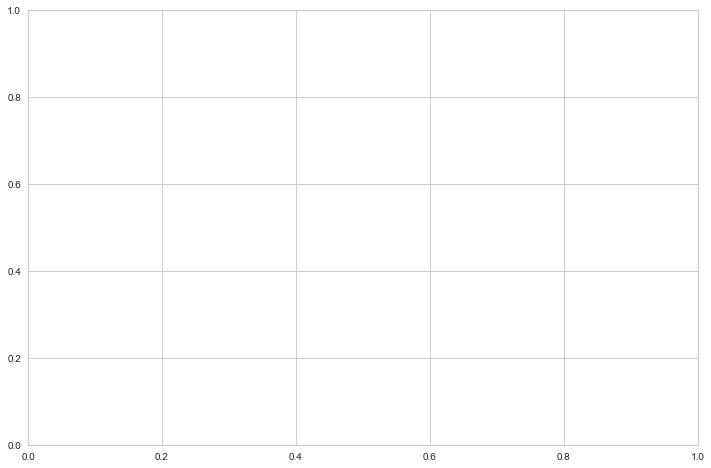

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,8))
antigenSpec = antigen[:1014]
controlSpec = control[:1014]
interferingSpec = interfering[:1014]

#spec2 = data[1014:2028]
plt.plot(antigenSpec[2], antigenSpec[3], '.r-', label = 'antigen')
plt.plot(controlSpec[2], controlSpec[3], '.g-', label = 'control')
plt.plot(interferingSpec[2], interferingSpec[3], '.b-', label = 'interfering')

#ax = plt.plot(spec2[2], spec2[3], '.b-')
ax.set(xlabel = 'comprimento da onda (1/cm)',
       ylabel = 'intensidade (u.a)',
       title = 'SERS')

plt.legend()
plt.show()

In [ ]:
# DataFrame de exemplo
data = {'Categoria': ['A', 'A', 'B', 'B', 'C', 'C'],
        'Valor': [10, 20, 30, 40, 50, 60]}
df = pd.DataFrame(data)

# Calcular a média dos valores para cada categoria
media_por_categoria = df.groupby('Categoria')['Valor'].mean()

print(media_por_categoria)


Categoria
A    15.0
B    35.0
C    55.0
Name: Valor, dtype: float64
